In [1]:
import os
import pickle
from tabulate import tabulate

os.environ['OMP_NUM_THREADS'] = '4'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openai
openai.api_key = os.environ['OPENAI_API_KEY']
openai.api_base = os.environ.get("OPENAI_API_BASE", "https://api.openai.com/v1")
from data.serialize import SerializerSettings
from models.utils import grid_iter
from models.promptcast import get_promptcast_predictions_data
from models.darts import get_arima_predictions_data
from models.llmtime import get_llmtime_predictions_data
from data.small_context import get_datasets
from data.small_context import get_bitcoin_datasets
from data.small_context import get_bitcoin_datasets_hourly

from models.validation_likelihood_tuning import get_autotuned_predictions_data

%load_ext autoreload
%autoreload 2

def plot_preds(train, test, pred_dict, model_name, show_samples=False, save_index = 0):
    save_folder = "./plot/" + str(save_index)
    pred = pred_dict['median']
    pred = pd.Series(pred, index=test.index)
    plt.figure(figsize=(8, 6), dpi=100)
    plt.plot(train)
    plt.plot(test, label='Truth', color='black')
    plt.plot(pred, label=model_name, color='purple')
    # shade 90% confidence interval
    samples = pred_dict['samples']
    lower = np.quantile(samples, 0.05, axis=0)
    upper = np.quantile(samples, 0.95, axis=0)
    plt.fill_between(pred.index, lower, upper, alpha=0.3, color='purple')
    if show_samples:
        samples = pred_dict['samples']
        # convert df to numpy array
        samples = samples.values if isinstance(samples, pd.DataFrame) else samples
        for i in range(min(10, samples.shape[0])):
            plt.plot(pred.index, samples[i], color='purple', alpha=0.3, linewidth=1)
    plt.legend(loc='upper left')
    if 'NLL/D' in pred_dict:
        nll = pred_dict['NLL/D']
        if nll is not None:
            plt.text(0.03, 0.85, f'NLL/D: {nll:.2f}', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
    plt.savefig(save_folder)
    plt.show()


def plot_preds_candles(df, train, test, pred_dict, model_name, show_samples=False, save_index = 0):

    save_folder = "./plot/" + str(save_index)
    pred = pred_dict['median']
    pred = pd.Series(pred)
    index = len(train)

    opens = pd.Series(df['open'].values, index=df['date'])
    truth = pd.Series(df['close'].values, index=df['date'])
    highs = pd.Series(df['high'].values, index=df['date'])
    lows = pd.Series(df['low'].values, index=df['date'])

    plt.figure(figsize=(8, 6), dpi=100)

    ## Draw candles
    height = truth - opens
    bottom = np.where(height > 0, opens, truth + abs(height))
    color = np.where(height > 0, 'g', 'r')

    plt.bar(range(len(truth)), height, bottom=bottom, color=color, align='center')
    plt.vlines(range(len(highs)), ymin=lows, ymax=highs, color=color, linewidth=1)            

    plt.plot(range(index, index + len(pred)), pred, label=model_name, color='purple')
    # shade 90% confidence interval
    samples = pred_dict['samples']
    lower = np.quantile(samples, 0.05, axis=0)
    upper = np.quantile(samples, 0.95, axis=0)
    plt.fill_between(range(index, index + len(pred)), lower, upper, alpha=0.3, color='purple')
    if show_samples:
        samples = pred_dict['samples']
        # convert df to numpy array
        samples = samples.values if isinstance(samples, pd.DataFrame) else samples
        for i in range(min(10, samples.shape[0])):
            plt.plot(range(index, index + len(pred)), samples[i], color='purple', alpha=0.3, linewidth=1)
    plt.legend(loc='upper left')
    if 'NLL/D' in pred_dict:
        nll = pred_dict['NLL/D']
        if nll is not None:
            plt.text(0.03, 0.85, f'NLL/D: {nll:.2f}', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))

    index_to_display = range(0, len(truth), len(truth) // 6)
    truth.index = truth.index.date
    display_date = truth.index[index_to_display]
    plt.xticks(index_to_display, display_date)

    # plt.xticks(range(len(truth)), truth.index)
    # plt.grid()

    plt.savefig(save_folder)
    plt.show()

/opt/anaconda3/envs/llmtime/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/anaconda3/envs/llmtime/lib/python3.9/site-packages/statsforecast/utils.py:237: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),


## Define models ##

In [2]:
gpt4_hypers = dict(
    alpha=0.3,
    basic=True,
    temp=1.0,
    top_p=0.8,
    settings=SerializerSettings(base=10, prec=3, signed=True, time_sep=', ', bit_sep='', minus_sign='-')
)

gpt3_hypers = dict(
    temp=0.7,
    alpha=0.95,
    beta=0.3,
    basic=False,
    settings=SerializerSettings(base=10, prec=3, signed=True, half_bin_correction=True)
)


promptcast_hypers = dict(
    temp=0.7,
    settings=SerializerSettings(base=10, prec=0, signed=True, 
                                time_sep=', ',
                                bit_sep='',
                                plus_sign='',
                                minus_sign='-',
                                half_bin_correction=False,
                                decimal_point='')
)

arima_hypers = dict(p=[12,30], d=[1,2], q=[0])

model_hypers = {
    'LLMTime GPT-3.5': {'model': 'gpt-3.5-turbo-instruct', **gpt3_hypers},
    'LLMTime GPT-4': {'model': 'gpt-4', **gpt4_hypers},
    # 'LLMTime GPT-3': {'model': 'text-davinci-004', **gpt3_hypers},
    # 'PromptCast GPT-3': {'model': 'text-davinci-004', **promptcast_hypers},
    # 'ARIMA': arima_hypers,
    
}

model_predict_fns = {
    # 'LLMTime GPT-3.5': get_llmtime_predictions_data,
    # 'LLMTime GPT-3': get_llmtime_predictions_data,
    'LLMTime GPT-4': get_llmtime_predictions_data,
    # 'PromptCast GPT-3': get_promptcast_predictions_data,
    # 'ARIMA': get_arima_predictions_data,
}

model_names = list(model_predict_fns.keys())

In [4]:
starting_date = '2023-11-01'
index = 0
for predict_step in [3,5,7] :

    with open(f"datasets/bitcoin/BTC_BitHourly.csv") as f:
        df = pd.read_csv(f, usecols=[0, 5], parse_dates=[0])
        mask = (df["timestamp"] > starting_date) 
        df = df.loc[mask]

        start_date = df["timestamp"].iloc[0]
        end_date = df["timestamp"].iloc[-1]

        print("Data set : BTC_Daily_ohlc")
        print(f"from {start_date} to {end_date}")
        print(f"{df.shape[0]} data points, training on {df.shape[0]- predict_step} and forecasting on {predict_step} points")
        print("Imput is scaled closing price")

    datasets = get_bitcoin_datasets_hourly(predict_steps=predict_step, timestamp="2023-11-01")
    ds_name = 'BTC_BitHourly'


    data = datasets[ds_name]
    train, test = data # or change to your own data
    print(train)

Data set : BTC_Daily_ohlc
from 2023-11-01 01:00:00 to 2023-11-29 10:00:00
682 data points, training on 610 and forecasting on 72 points
Imput is scaled closing price
timestamp
2023-11-01 01:00:00    34439.0
2023-11-01 02:00:00    34392.0
2023-11-01 03:00:00    34487.0
2023-11-01 04:00:00    34553.0
2023-11-01 05:00:00    34652.0
                        ...   
2023-11-26 06:00:00    37823.0
2023-11-26 07:00:00    37757.0
2023-11-26 08:00:00    37809.0
2023-11-26 09:00:00    37764.0
2023-11-26 10:00:00    37710.0
Length: 610, dtype: float64
Data set : BTC_Daily_ohlc
from 2023-11-01 01:00:00 to 2023-11-29 10:00:00
682 data points, training on 562 and forecasting on 120 points
Imput is scaled closing price
timestamp
2023-11-01 01:00:00    34439.0
2023-11-01 02:00:00    34392.0
2023-11-01 03:00:00    34487.0
2023-11-01 04:00:00    34553.0
2023-11-01 05:00:00    34652.0
                        ...   
2023-11-24 06:00:00    37257.0
2023-11-24 07:00:00    37309.0
2023-11-24 08:00:00    37301.0

Data set : BTC_Daily_ohlc
from 2023-11-17 to 2023-01-01
training on 6 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

targets [37294.55647805 37714.82723583 37781.67706375 37447.9711725
 37242.57459525 37820.32685866 37855.02595743]
median date
2023-11-23 09:00:00    37414.955053
2023-11-24 09:00:00    36573.347262
2023-11-25 09:00:00    37396.659232
2023-11-26 09:00:00    37433.250875
2023-11-27 09:00:00    37396.659232
2023-11-28 09:00:00    37469.842518
2023-11-29 09:00:00    37451.546697
dtype: float64
Raw list completion :
[['1010, 1025, 939, 1021', '975, 1021, 974, 1020, 973, 1019', '1034, 975, 1033', '1025, 952, 1027, 1029, 928, 1031, 1033, ', '1033, 1022, 1055, 981, 1022, 1034, 1022,', '1045, 1024, 973, 1021, 1069, 1025', '1021, 977, 1020, 1022, 978, 1019', '1023, 952, 1024', '979, 1025, 982, 1024, 985, 1023', '1021, 977, 1023']]
Model :  LLMTime GPT-4
MAE :  367.0949880416052
MAES :  253614.94668162617
dic_error_median :  {'input_length': {6: {'Mae': 367.0949880416052, 'Mse': 253614.94668162617}, 12: {'Mae': None, 'Mse': None}, 24: {'Mae': None, 'Mse': None}, 48: {'Mae': None, 'Mse': None}, 9

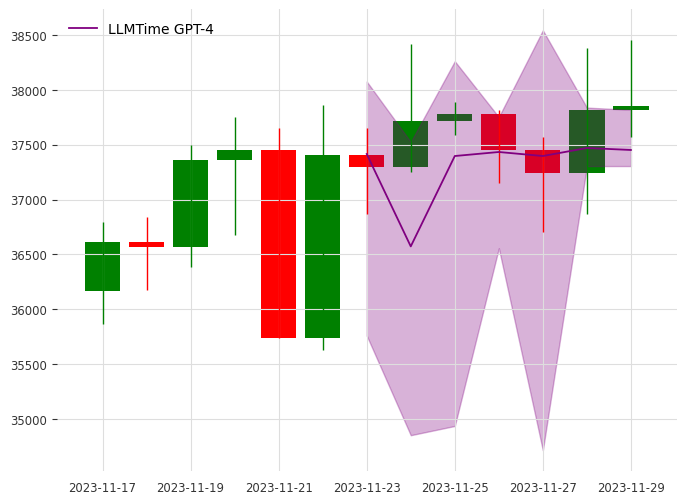

Data set : BTC_Daily_ohlc
from 2023-11-11 to 2023-01-01
training on 12 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.69s/it]

targets [37294.55647805 37714.82723583 37781.67706375 37447.9711725
 37242.57459525 37820.32685866 37855.02595743]
median date
2023-11-23 09:00:00    36823.842546
2023-11-24 09:00:00    36769.099470
2023-11-25 09:00:00    37152.301003
2023-11-26 09:00:00    37280.034848
2023-11-27 09:00:00    36349.402553
2023-11-28 09:00:00    37115.805619
2023-11-29 09:00:00    36568.374858
dtype: float64
Raw list completion :
[['1009, 1019, 979, 1000, 996, 993, 978, 1011, ', '1008, 1007, 1018, 1031, 984, 1030, 1013, 101', '1013, 1007, 998, 1033, 983, 1011, 1009, 1015', '993, 987, 1017, 1031, 987, 1020, 1006, 997, ', '1000, 1014, 1021, 1030, 1007, 1027, 1016, ', '1019, 1013, 980, 1014, 1022, 1010, 983, 1003', '1018, 993, 1050, 1010, 1001, 1048, 980, 1032', '1001, 1000, 1019, 1022, 977, 1021, 997, 998,', '1019, 1022, 981, 1015, 1017, 1010, 1005, 101', '995, 1004, 1031, 1020, 995, 1013, 998, 1006,']]
Model :  LLMTime GPT-4
MAE :  728.2997805762227
MAES :  641409.5675455375
dic_error_median :  {'input_l

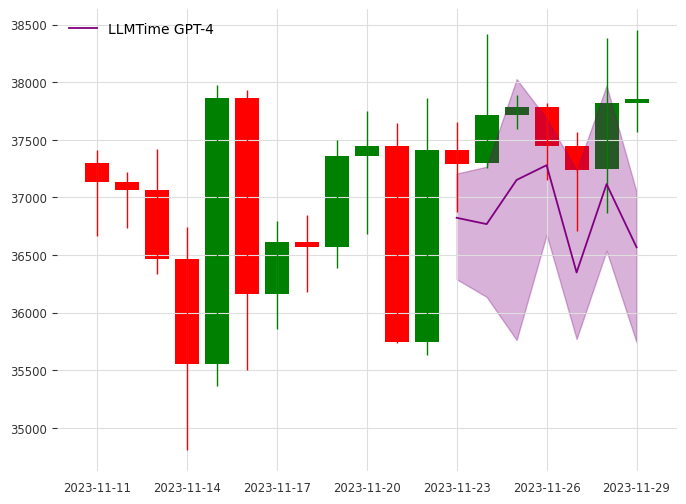

Data set : BTC_Daily_ohlc
from 2023-10-30 to 2023-01-01
training on 24 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

targets [37294.55647805 37714.82723583 37781.67706375 37447.9711725
 37242.57459525 37820.32685866 37855.02595743]
median date
2023-11-23 09:00:00    37417.338511
2023-11-24 09:00:00    37717.950399
2023-11-25 09:00:00    37824.048712
2023-11-26 09:00:00    37523.436824
2023-11-27 09:00:00    37894.780921
2023-11-28 09:00:00    38053.928391
2023-11-29 09:00:00    37947.830078
dtype: float64
Raw list completion :
[['1067, 1089, 1075, 1069, 1079, 1078, 1078, 108', '1055, 1060, 1044, 1038, 1058, 1057, 1057, 106', '1008, 1063, 1054, 1046, 1061, 1060, 1072, 107', '1062, 1084, 1070, 1064, 1074, 1073, 1073, 108', '1066, 1079, 1087, 1074, 1068, 1090, 1117, 112', '1044, 1049, 1071, 1057, 1051, 1061, 1060, 106', '1055, 1061, 1042, 1038, 1074, 1083, 1051, 104', '1060, 1065, 1068, 1073, 1075, 1080, 1082, 108', '1064, 1073, 1087, 1081, 1091, 1090, 1090, 110', '1015, 1067, 1051, 1012, 1049, 1016, 1071, 104']]
Model :  LLMTime GPT-4
MAE :  174.62206793385536
MAES :  73018.71076919393
dic_error_median

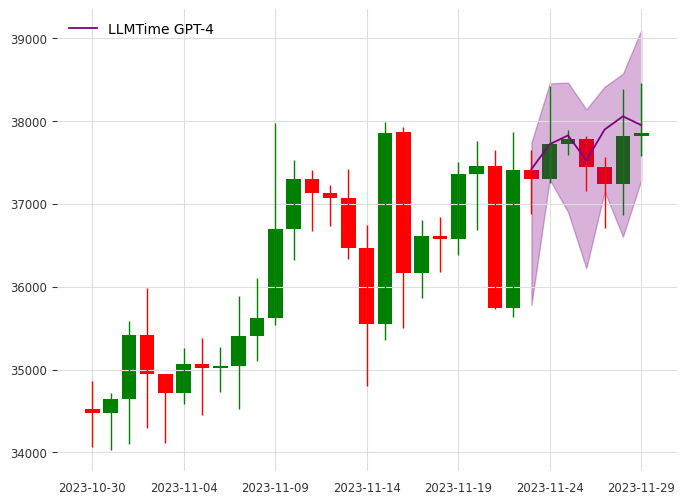

Data set : BTC_Daily_ohlc
from 2023-10-06 to 2023-01-01
training on 48 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]

targets [37294.55647805 37714.82723583 37781.67706375 37447.9711725
 37242.57459525 37820.32685866 37855.02595743]
median date
2023-11-23 09:00:00    37547.976924
2023-11-24 09:00:00    37622.211754
2023-11-25 09:00:00    37681.599618
2023-11-26 09:00:00    38008.232869
2023-11-27 09:00:00    38097.314665
2023-11-28 09:00:00    38379.407018
2023-11-29 09:00:00    38438.794882
dtype: float64
Raw list completion :
[['1261, 1251, 1255, 1252, 1243, 1249, 1264, 1263', '1271, 1274, 1267, 1279, 1277, 1293, 1287, 1302', '1264, 1271, 1280, 1295, 1298, 1310, 1307, 1319', '1250, 1253, 1277, 1280, 1283, 1224, 1281, 1272', '1286, 1300, 1332, 1378, 1389, 1393, 1414, 1421', '1270, 1257, 1264, 1273, 1282, 1296, 1300, 1302', '1264, 1287, 1290, 1280, 1282, 1291, 1312, 1333', '1263, 1264, 1259, 1250, 1242, 1235, 1230, 1227', '1268, 1269, 1270, 1290, 1293, 1294, 1322, 1341', '1237, 1256, 1260, 1278, 1284, 1232, 1288, 1270']]
Model :  LLMTime GPT-4
MAE :  429.13774625070903
MAES :  254377.94025683234
dic_e

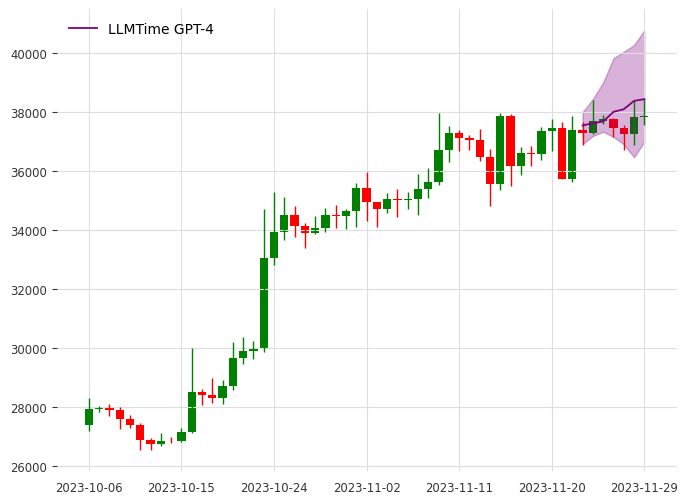

Data set : BTC_Daily_ohlc
from 2023-08-19 to 2023-01-01
training on 96 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.47s/it]

targets [37294.55647805 37714.82723583 37781.67706375 37447.9711725
 37242.57459525 37820.32685866 37855.02595743]
median date
2023-11-23 09:00:00    37387.588965
2023-11-24 09:00:00    37414.114392
2023-11-25 09:00:00    37467.165245
2023-11-26 09:00:00    37811.995793
2023-11-27 09:00:00    38103.775487
2023-11-28 09:00:00    38090.512773
2023-11-29 09:00:00    37891.572073
dtype: float64
Raw list completion :
[['1401, 1400, 1427, 1443, 1466, 1449, 1454, 1436', '1376, 1393, 1403, 1452, 1496, 1488, 1478, 1455', '1412, 1411, 1414, 1427, 1438, 1430, 1436, 1450', '1398, 1384, 1397, 1416, 1450, 1443, 1441, 1418', '1415, 1409, 1390, 1388, 1391, 1389, 1420, 1419', '1382, 1414, 1410, 1423, 1434, 1441, 1460, 1459', '1421, 1428, 1429, 1410, 1414, 1415, 1398, 1419', '1421, 1398, 1396, 1385, 1394, 1398, 1414, 1386', '1412, 1426, 1435, 1428, 1427, 1419, 1404, 1428', '1406, 1430, 1436, 1472, 1478, 1484, 1412, 1435']]
Model :  LLMTime GPT-4
MAE :  320.0306701055327
MAES :  163788.26975752081
dic_er

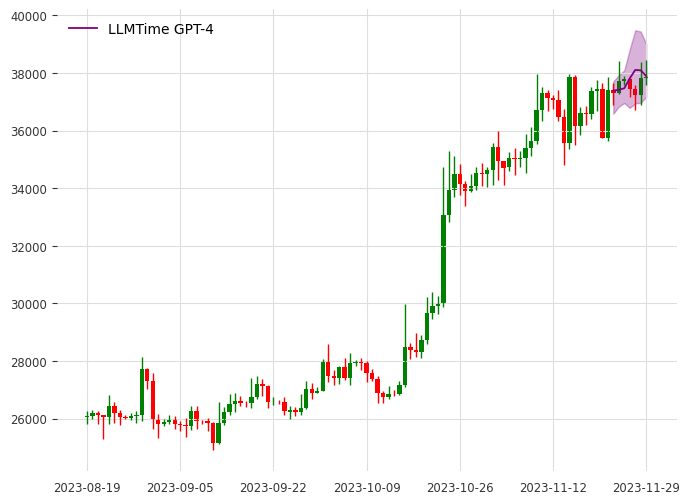

Data set : BTC_Daily_ohlc
from 2023-05-15 to 2023-01-01
training on 192 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]

targets [37294.55647805 37714.82723583 37781.67706375 37447.9711725
 37242.57459525 37820.32685866 37855.02595743]
median date
2023-11-23 09:00:00    37304.441965
2023-11-24 09:00:00    37304.441965
2023-11-25 09:00:00    37331.270043
2023-11-26 09:00:00    36942.262917
2023-11-27 09:00:00    36741.052335
2023-11-28 09:00:00    37022.747150
2023-11-29 09:00:00    37183.715616
dtype: float64
Raw list completion :
[['1362, 1338, 1337, 1335, 1332, 1327, 1328, 1358', '1389, 1334, 1390, 1388, 1334, 1376, 1387, 1329', '1389, 1391, 1376, 1369, 1358, 1351, 1347, 1327', '1393, 1389, 1392, 1348, 1367, 1376, 1385, 1349', '1399, 1403, 1402, 1407, 1409, 1411, 1416, 1422', '1419, 1413, 1407, 1401, 1396, 1391, 1386, 1381', '1363, 1366, 1366, 1362, 1359, 1358, 1361, 1365', '1379, 1382, 1395, 1374, 1371, 1383, 1377, 1376', '1397, 1410, 1413, 1418, 1422, 1429, 1433, 1438', '1391, 1396, 1375, 1379, 1381, 1386, 1389, 1391']]
Model :  LLMTime GPT-4
MAE :  478.1140492232475
MAES :  280776.66586065496
dic_er

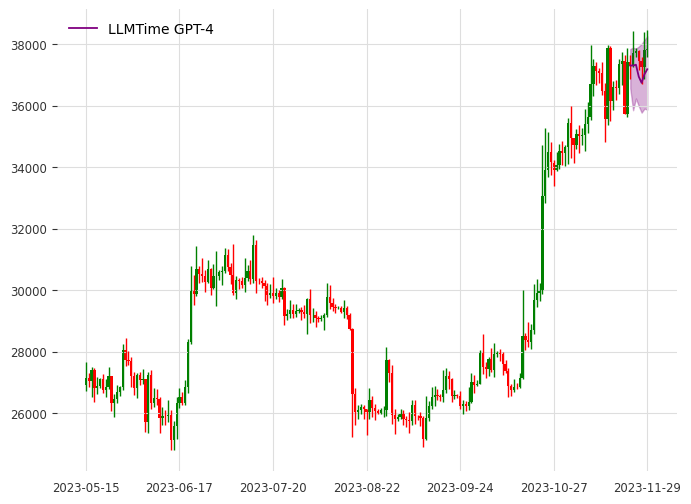

Two pickle files have been created one with MSE/MAE among all samples and the second with MSE/MAE among median only
The path for the pickle file are the following : 
pickle/dic_error_classic_2023-11-30_median.pkl
Data set : BTC_Daily_ohlc
from 2023-11-23 to 2023-01-01
training on 6 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]

targets [37855.02595743 37723.7235402  38683.3820931  39451.21160246
 39972.88180039 41990.91660753 44073.37726559]
median date
2023-11-29 09:00:00    37875.775887
2023-11-30 09:00:00    37576.805776
2023-12-01 09:00:00    37352.578193
2023-12-02 09:00:00    37950.518415
2023-12-03 09:00:00    37987.889678
2023-12-04 09:00:00    37763.662095
2023-12-05 09:00:00    37539.434512
dtype: float64
Raw list completion :
[['1013, 1005, 999, 1015, 1016, 1008', '1013, 1005, 999, 1015', '1014, 1008, 1000, 1016, 1018, 1012, 1004', '1014, 1006, 1000, 1016, 1018, 1010, 1004', '1024, 1016, 1010, 1026', '1013, 1005, 999, 1015, 1016, 1008, 1002,', '1011, 1003, 997, 1013, 1012, 1004, 998, ', '1013, 1005, 999, 1015, 1016, 1008, 1002', '1014, 1006, 1000, 1016, 1018, 1010, 1004', '1013, 1005, 999, 1015']]
Model :  LLMTime GPT-4
MAE :  2249.3363097406213
MAES :  9792488.112541761
dic_error_median :  {'input_length': {6: {'Mae': 2249.3363097406213, 'Mse': 9792488.112541761}, 12: {'Mae': None, 'Mse': None}, 2

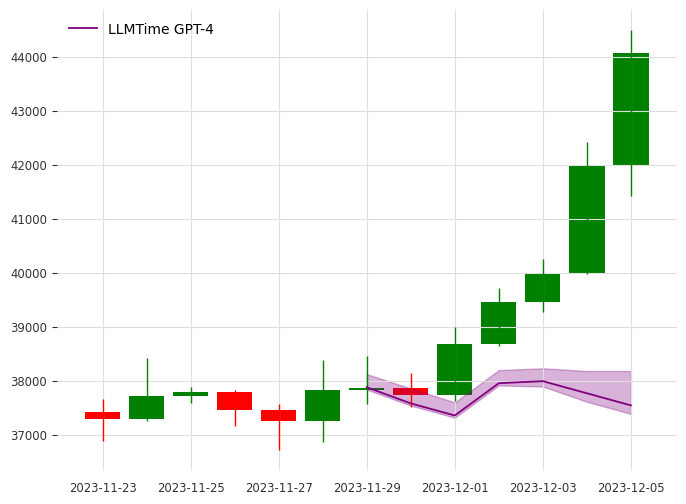

Data set : BTC_Daily_ohlc
from 2023-11-17 to 2023-01-01
training on 12 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.83s/it]

targets [37855.02595743 37723.7235402  38683.3820931  39451.21160246
 39972.88180039 41990.91660753 44073.37726559]
median date
2023-11-29 09:00:00    37686.638105
2023-11-30 09:00:00    37872.928951
2023-12-01 09:00:00    37835.670782
2023-12-02 09:00:00    37612.121767
2023-12-03 09:00:00    37891.558036
2023-12-04 09:00:00    37891.558036
2023-12-05 09:00:00    37872.928951
dtype: float64
Raw list completion :
[['1006, 1011, 1009, 1019, 1023, 1010, 1007, ', '1005, 1016, 1014, 1006, 1000, 1016, 1016, ', '1010, 1016, 1009, 1003, 1017, 1006, 1018, ', '1012, 1020, 1021, 1013, 1008, 1022, 1020, ', '1001, 1021, 1025, 1008, 1020, 1017, 1034, ', '1017, 1019, 1016, 1018, 1021, 1024, 1021, ', '1011, 1017, 1019, 1010, 1004, 1020, 1016, ', '1019, 998, 1012, 1004, 1016, 1018, 1009, 100', '1016, 1006, 1000, 1017, 1018, 1007, 1001, ', '1011, 1016, 1017, 1006, 1000, 1016, 1012, ']]
Model :  LLMTime GPT-4
MAE :  2197.932151436066
MAES :  9104813.032015832
dic_error_median :  {'input_length': {6: {'M

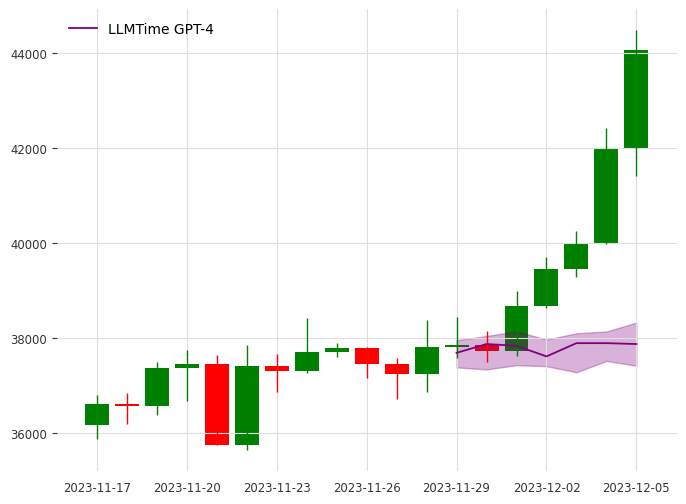

Data set : BTC_Daily_ohlc
from 2023-11-05 to 2023-01-01
training on 24 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.99s/it]

targets [37855.02595743 37723.7235402  38683.3820931  39451.21160246
 39972.88180039 41990.91660753 44073.37726559]
median date
2023-11-29 09:00:00    37508.667880
2023-11-30 09:00:00    37563.318683
2023-12-01 09:00:00    37654.403355
2023-12-02 09:00:00    37526.884814
2023-12-03 09:00:00    37526.884814
2023-12-04 09:00:00    37454.017077
2023-12-05 09:00:00    37690.837224
dtype: float64
Raw list completion :
[['1036, 1029, 1027, 1035, 1032, 1028, 1034, 103', '1036, 1005, 1038, 1027, 1039, 1027, 1023, 104', '1028, 1032, 1037, 1042, 1044, 1039, 1041, 104', '1029, 1034, 1040, 1042, 1028, 1043, 1040, 105', '1036, 1042, 1043, 1028, 1033, 1029, 1031, 104', '1036, 1033, 1028, 1030, 1031, 1024, 1035, 102', '1029, 1034, 1031, 1028, 1022, 1039, 1034, 102', '1029, 1026, 1034, 1037, 1028, 1025, 1039, 103', '1023, 1021, 1022, 1020, 1018, 1019, 1017, 101', '1029, 1026, 1032, 1029, 1028, 1025, 1022, 102']]
Model :  LLMTime GPT-4
MAE :  2403.643574262598
MAES :  10315814.351756927
dic_error_media

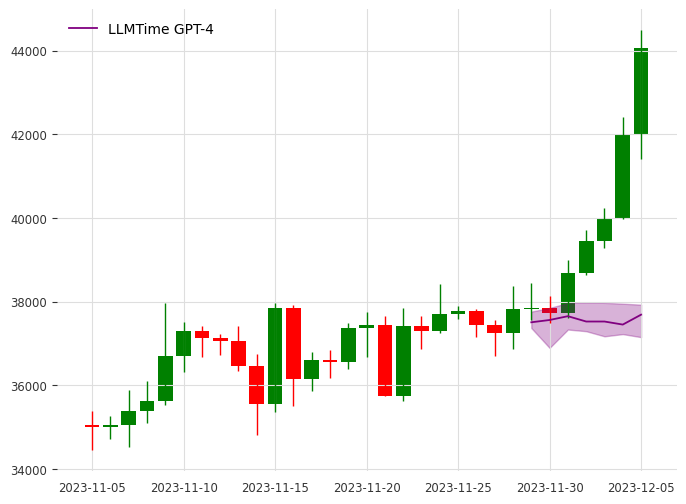

Data set : BTC_Daily_ohlc
from 2023-10-12 to 2023-01-01
training on 48 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


targets [37855.02595743 37723.7235402  38683.3820931  39451.21160246
 39972.88180039 41990.91660753 44073.37726559]
median date
2023-11-29 09:00:00    37906.441243
2023-11-30 09:00:00    37923.485507
2023-12-01 09:00:00    38076.883875
2023-12-02 09:00:00    38076.883875
2023-12-03 09:00:00    38332.547822
2023-12-04 09:00:00    38366.636348
2023-12-05 09:00:00    38417.769138
dtype: float64
Raw list completion :
[['1112, 1115, 1120, 1122, 1136, 1140, 1142, 1146', '1104, 1112, 1120, 1114, 1118, 1126, 1122, 1120', '1116, 1112, 1122, 1125, 1140, 1135, 1127, 1130', '1104, 1108, 1112, 1106, 1108, 1110, 1116, 1118', '1113, 1111, 1119, 1122, 1134, 1145, 1159, 1164', '1116, 1123, 1121, 1129, 1129, 1137, 1133, 1137', '1097, 1110, 1111, 1112, 1103, 1114, 1114, 1126', '1111, 1116, 1114, 1119, 1127, 1123, 1127, 1132', '1106, 1108, 1110, 1112, 1114, 1116, 1118, 1120', '1112, 1114, 1109, 1104, 1121, 1124, 1126, 1121']]
Model :  LLMTime GPT-4
MAE :  1878.8893661708603
MAES :  7158738.773923157
dic_e

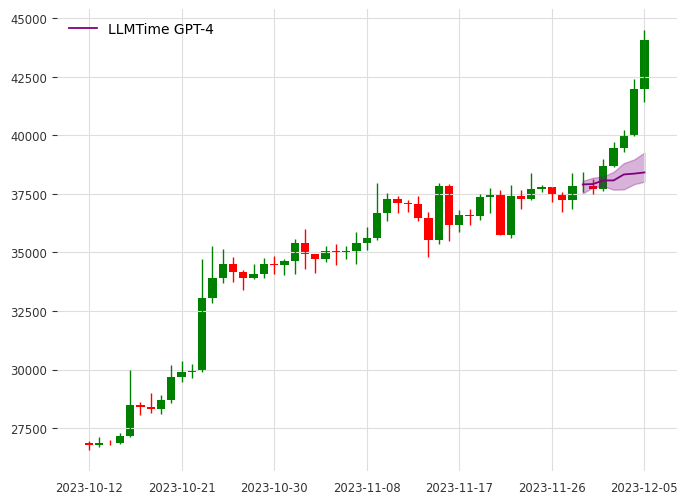

Data set : BTC_Daily_ohlc
from 2023-08-25 to 2023-01-01
training on 96 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:02<00:00,  2.33s/it]

targets [37855.02595743 37723.7235402  38683.3820931  39451.21160246
 39972.88180039 41990.91660753 44073.37726559]
median date
2023-11-29 09:00:00    37685.372341
2023-11-30 09:00:00    37605.332612
2023-12-01 09:00:00    37632.012522
2023-12-02 09:00:00    37685.372341
2023-12-03 09:00:00    37605.332612
2023-12-04 09:00:00    37712.052251
2023-12-05 09:00:00    37792.091979
dtype: float64
Raw list completion :
[['1417, 1409, 1408, 1420, 1423, 1416, 1413, 1417', '1413, 1412, 1409, 1411, 1408, 1410, 1417, 1421', '1415, 1409, 1411, 1413, 1410, 1429, 1424, 1422', '1410, 1388, 1383, 1380, 1387, 1397, 1380, 1395', '1414, 1416, 1430, 1425, 1429, 1398, 1412, 1401', '1403, 1408, 1404, 1410, 1396, 1385, 1388, 1389', '1419, 1422, 1419, 1420, 1423, 1425, 1430, 1432', '1393, 1385, 1409, 1407, 1401, 1418, 1429, 1438', '1411, 1409, 1412, 1420, 1398, 1431, 1425, 1418', '1408, 1414, 1418, 1411, 1410, 1409, 1415, 1410']]
Model :  LLMTime GPT-4
MAE :  2290.4217441879987
MAES :  9662125.603812587
dic_e

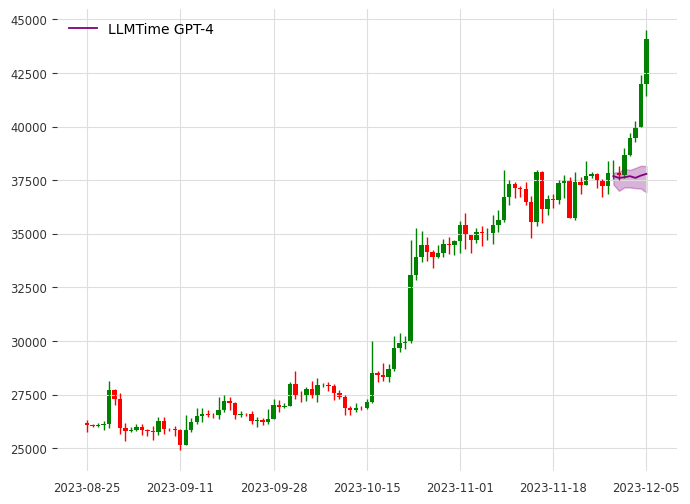

Data set : BTC_Daily_ohlc
from 2023-05-21 to 2023-01-01
training on 192 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


targets [37855.02595743 37723.7235402  38683.3820931  39451.21160246
 39972.88180039 41990.91660753 44073.37726559]
median date
2023-11-29 09:00:00    37691.541980
2023-11-30 09:00:00    37664.696152
2023-12-01 09:00:00    37731.810721
2023-12-02 09:00:00    37866.039859
2023-12-03 09:00:00    37892.885687
2023-12-04 09:00:00    37839.194032
2023-12-05 09:00:00    38080.806480
dtype: float64
Raw list completion :
[['1406, 1405, 1402, 1409, 1398, 1386, 1382, 1390', '1403, 1400, 1397, 1395, 1433, 1429, 1436, 1425', '1390, 1397, 1412, 1423, 1420, 1411, 1421, 1414', '1404, 1419, 1423, 1411, 1422, 1418, 1440, 1432', '1388, 1370, 1376, 1370, 1389, 1396, 1363, 1364', '1388, 1391, 1393, 1411, 1452, 1437, 1433, 1440', '1407, 1414, 1412, 1403, 1402, 1407, 1415, 1409', '1408, 1411, 1421, 1423, 1427, 1433, 1451, 1461', '1397, 1386, 1389, 1392, 1388, 1387, 1398, 1388', '1409, 1406, 1408, 1426, 1383, 1391, 1388, 1386']]
Model :  LLMTime GPT-4
MAE :  2140.5062794359933
MAES :  8703222.510460561
dic_e

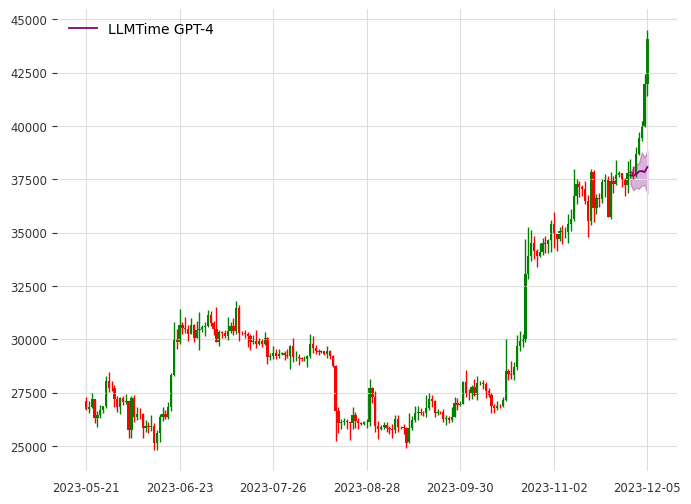

Two pickle files have been created one with MSE/MAE among all samples and the second with MSE/MAE among median only
The path for the pickle file are the following : 
pickle/dic_error_classic_2023-12-06_median.pkl
Data set : BTC_Daily_ohlc
from 2023-11-29 to 2023-01-01
training on 6 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.67s/it]

targets [44073.37726559 43762.72930581 43273.70456916 44171.83380836
 43713.53595401 43789.35550156 41252.79968239]
median date
2023-12-05 09:00:00    43856.507813
2023-12-06 09:00:00    45502.083586
2023-12-07 09:00:00    47492.082195
2023-12-08 09:00:00    49386.407795
2023-12-09 09:00:00    50553.618517
2023-12-10 09:00:00    51127.656578
2023-12-11 09:00:00    51127.656578
dtype: float64
Raw list completion :
[['1185, 1207, 1242, 1304', '1146, 1197, 1246, 1301, 1354, 1405', '1131, 1170, 1207, 1249, 1290, 1334', '1135, 1178, 1226, 1279, 1337', '1139, 1174, 1199, 1230, 1276', '1170, 1206, 1259, 1328, 1376, 1431', '1147, 1181, 1239, 1264', '1145, 1198, 1256, 1319, 1387, 1460', '1148, 1196, 1247, 1304, 1362', '1115, 1139, 1165, 1192, 1222']]
Model :  LLMTime GPT-4
MAE :  5063.202268607139
MAES :  35172724.0270972
dic_error_median :  {'input_length': {6: {'Mae': 5063.202268607139, 'Mse': 35172724.0270972}, 12: {'Mae': None, 'Mse': None}, 24: {'Mae': None, 'Mse': None}, 48: {'Mae': None,

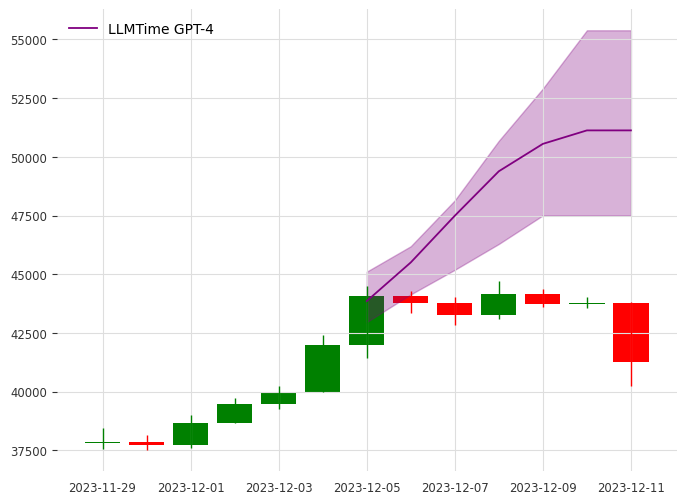

Data set : BTC_Daily_ohlc
from 2023-11-23 to 2023-01-01
training on 12 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:02<00:00,  2.40s/it]

targets [44073.37726559 43762.72930581 43273.70456916 44171.83380836
 43713.53595401 43789.35550156 41252.79968239]
median date
2023-12-05 09:00:00    43016.804333
2023-12-06 09:00:00    44261.481705
2023-12-07 09:00:00    45770.181550
2023-12-08 09:00:00    47731.491349
2023-12-09 09:00:00    49523.072415
2023-12-10 09:00:00    51352.370977
2023-12-11 09:00:00    53558.844501
dtype: float64
Raw list completion :
[['1145, 1204, 1282, 1363, 1469, 1589', '1161, 1199, 1225, 1277, 1321, 1353, 1401, ', '1153, 1187, 1245, 1315, 1413, 1539', '1133, 1153, 1167, 1221, 1241, 1261, 1275, ', '1177, 1213, 1289, 1349, 1437, 1513, 1637, ', '1114, 1124, 1128, 1131, 1143, 1157, 1162, ', '1144, 1174, 1206, 1253, 1304, 1369, 1438, ', '1136, 1172, 1220, 1281, 1345, 1423, 1505', '1114, 1123, 1136, 1149, 1167, 1189, 1215, ', '1113, 1130, 1165, 1188, 1207, 1249, 1285, ']]
Model :  LLMTime GPT-4
MAE :  4755.722372606801
MAES :  37522473.640198335
dic_error_median :  {'input_length': {6: {'Mae': 5063.202268607

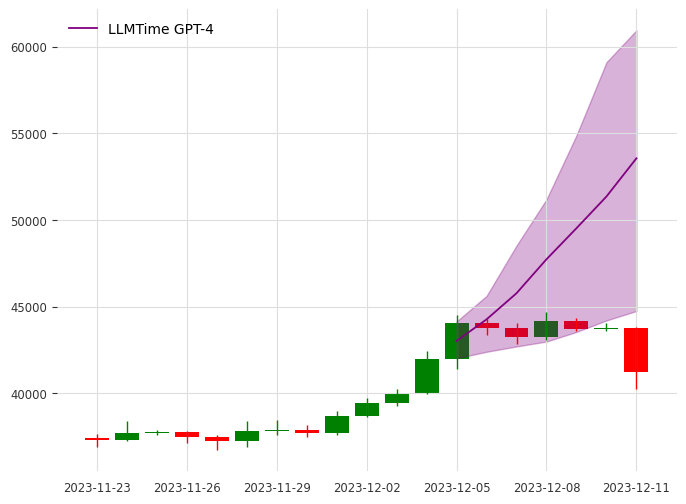

Data set : BTC_Daily_ohlc
from 2023-11-11 to 2023-01-01
training on 24 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.95s/it]

targets [44073.37726559 43762.72930581 43273.70456916 44171.83380836
 43713.53595401 43789.35550156 41252.79968239]
median date
2023-12-05 09:00:00    42841.270891
2023-12-06 09:00:00    44122.054119
2023-12-07 09:00:00    45699.830560
2023-12-08 09:00:00    47871.593426
2023-12-09 09:00:00    49746.363079
2023-12-10 09:00:00    51825.315566
2023-12-11 09:00:00    53662.961068
dtype: float64
Raw list completion :
[['1164, 1201, 1244, 1295, 1350, 1411, 1478, 155', '1144, 1175, 1217, 1286, 1342, 1413, 1497, 159', '1138, 1155, 1192, 1218, 1263, 1314, 1351, 140', '1105, 1135, 1163, 1200, 1246, 1301, 1348, 140', '1163, 1205, 1263, 1332, 1398, 1479, 1571, 166', '1165, 1204, 1257, 1318, 1385, 1460', '1116, 1122, 1121, 1142, 1144, 1098, 1143, 114', '1188, 1229, 1275, 1329, 1382, 1439, 1500, 156', '1172, 1205, 1245, 1292, 1337, 1380, 1430, 147', '1142, 1160, 1193, 1217, 1249, 1262, 1284, 130']]
Model :  LLMTime GPT-4
MAE :  4885.180767578854
MAES :  39457895.985990405
dic_error_median :  {'inpu

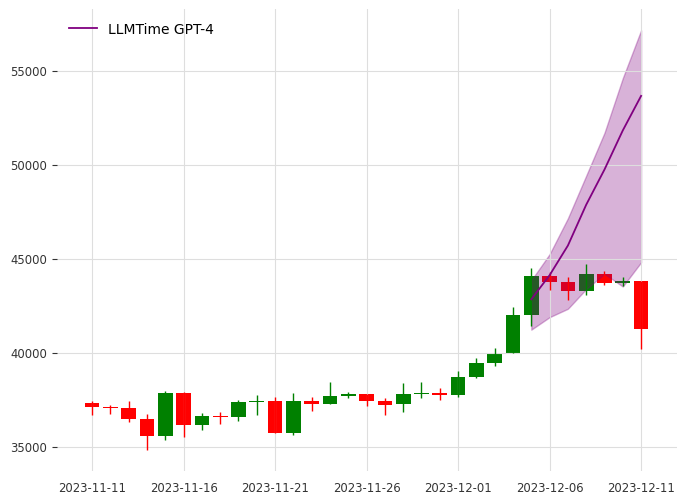

Data set : BTC_Daily_ohlc
from 2023-10-18 to 2023-01-01
training on 48 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.95s/it]

targets [44073.37726559 43762.72930581 43273.70456916 44171.83380836
 43713.53595401 43789.35550156 41252.79968239]
median date
2023-12-05 09:00:00    42555.951544
2023-12-06 09:00:00    42816.498186
2023-12-07 09:00:00    43424.440351
2023-12-08 09:00:00    43737.096322
2023-12-09 09:00:00    44483.996696
2023-12-10 09:00:00    46116.755653
2023-12-11 09:00:00    47019.984012
dtype: float64
Raw list completion :
[['1232, 1247, 1276, 1321, 1327, 1335, 1364, 1390', '1233, 1256, 1273, 1292, 1325, 1358, 1382, 1409', '1215, 1220, 1237, 1245, 1254, 1260, 1271, 1282', '1233, 1247, 1258, 1301, 1323, 1350, 1376, 1401', '1210, 1206, 1221, 1232, 1239, 1290, 1295, 1303', '1214, 1226, 1249, 1255, 1258, 1346, 1371, 1387', '1233, 1235, 1232, 1260, 1282, 1297, 1355, 1380', '1210, 1203, 1215, 1218, 1209, 1204, 1220, 1221', '1220, 1229, 1256, 1275, 1278, 1320, 1335, 1350', '1229, 1245, 1250, 1257, 1308, 1334, 1351, 1342']]
Model :  LLMTime GPT-4
MAE :  1702.0250475348419
MAES :  6097209.774996938
dic_e

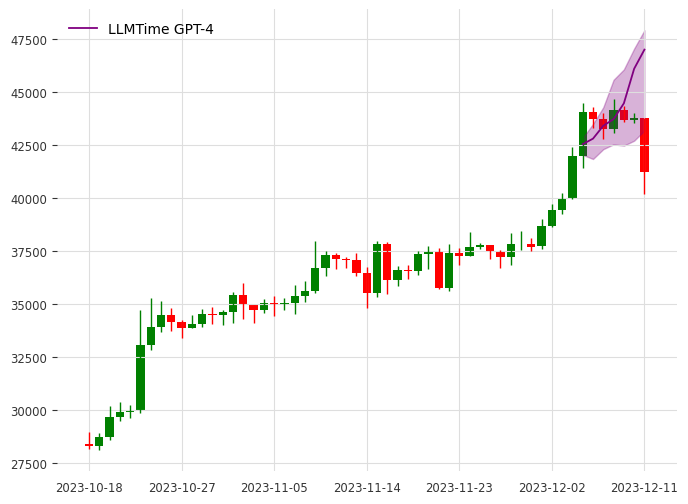

Data set : BTC_Daily_ohlc
from 2023-08-31 to 2023-01-01
training on 96 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.53s/it]

targets [44073.37726559 43762.72930581 43273.70456916 44171.83380836
 43713.53595401 43789.35550156 41252.79968239]
median date
2023-12-05 09:00:00    42291.566322
2023-12-06 09:00:00    42237.828627
2023-12-07 09:00:00    42425.910561
2023-12-08 09:00:00    42412.476137
2023-12-09 09:00:00    42613.992495
2023-12-10 09:00:00    42748.336733
2023-12-11 09:00:00    42922.984244
dtype: float64
Raw list completion :
[['1585, 1580, 1591, 1588, 1597, 1601, 1605, 1620', '1572, 1583, 1591, 1589, 1607, 1610, 1609, 1618', '1581, 1579, 1568, 1557, 1558, 1562, 1564, 1568', '1560, 1595, 1602, 1596, 1586, 1583, 1601, 1603', '1563, 1555, 1549, 1559, 1580, 1578, 1558, 1581', '1575, 1572, 1579, 1568, 1569, 1617, 1621, 1665', '1563, 1567, 1577, 1579, 1585, 1595, 1603, 1618', '1563, 1552, 1547, 1553, 1577, 1573, 1566, 1589', '1575, 1571, 1578, 1577, 1589, 1604, 1593, 1620', '1587, 1565, 1589, 1580, 1588, 1586, 1561, 1569']]
Model :  LLMTime GPT-4
MAE :  1389.230013073791
MAES :  2056642.682927542
dic_er

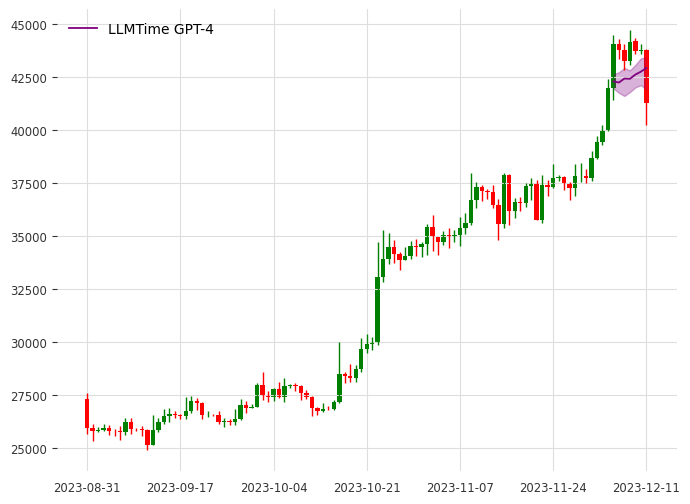

Data set : BTC_Daily_ohlc
from 2023-05-27 to 2023-01-01
training on 192 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


targets [44073.37726559 43762.72930581 43273.70456916 44171.83380836
 43713.53595401 43789.35550156 41252.79968239]
median date
2023-12-05 09:00:00    42034.633195
2023-12-06 09:00:00    42330.367743
2023-12-07 09:00:00    42370.695181
2023-12-08 09:00:00    42706.757167
2023-12-09 09:00:00    42868.066920
2023-12-10 09:00:00    43459.536015
2023-12-11 09:00:00    43701.500645
dtype: float64
Raw list completion :
[['1564, 1578, 1572, 1585, 1593, 1602, 1600, 1627', '1568, 1564, 1569, 1586, 1585, 1588, 1590, 1591', '1575, 1593, 1605, 1620, 1622, 1626, 1630, 1652', '1560, 1593, 1604, 1622, 1640, 1653, 1678, 1690', '1575, 1593, 1579, 1590, 1586, 1585, 1583, 1578', '1568, 1570, 1565, 1558, 1562, 1564, 1572, 1578', '1555, 1568, 1581, 1605, 1610, 1637, 1639, 1646', '1562, 1581, 1585, 1611, 1634, 1637, 1684, 1712', '1562, 1567, 1571, 1583, 1595, 1610, 1620, 1628', '1552, 1555, 1569, 1571, 1589, 1622, 1641, 1658']]
Model :  LLMTime GPT-4
MAE :  1351.883020868714
MAES :  2284249.6769283875
dic_e

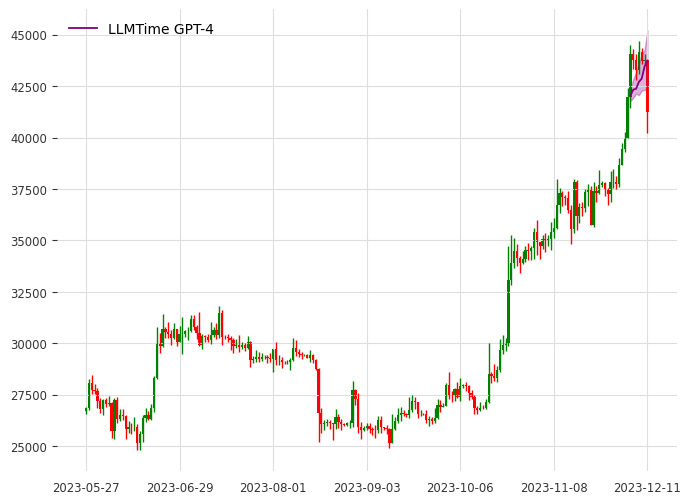

Two pickle files have been created one with MSE/MAE among all samples and the second with MSE/MAE among median only
The path for the pickle file are the following : 
pickle/dic_error_classic_2023-12-12_median.pkl
Data set : BTC_Daily_ohlc
from 2023-12-05 to 2023-01-01
training on 6 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]

targets [41252.79968239 41491.14066286 42870.06425447 43022.65724186
 41939.53711693 42277.12350777 41373.37649145]
median date
2023-12-11 09:00:00    43628.787298
2023-12-12 09:00:00    43803.739829
2023-12-13 09:00:00    43716.263564
2023-12-14 09:00:00    43891.216094
2023-12-15 09:00:00    43519.441967
2023-12-16 09:00:00    44131.775824
2023-12-17 09:00:00    43803.739829
dtype: float64
Raw list completion :
[['1003, 997, 1005, 995, 1007, 993, 1009, 991', '1004, 997, 986, 1006, 996, 998', '1009, 999, 1003', '1008, 998, 1009, 999, 1004', '989, 1011, 999, 1003, 991, 1013, 1001, 100', '989, 1011, 999, 1003, 989, 1013, 999, 1005', '989, 1011, 999, 1003, 991, 1013, 1001, 100', '1011, 997, 1013', '991, 1011, 998, 1003, 993, 1013, 997, 1005', '987, 1003, 995, 999, 985, 997, 993']]
Model :  LLMTime GPT-4
MAE :  1752.6093494796753
MAES :  3472340.0433016107
dic_error_median :  {'input_length': {6: {'Mae': 1752.6093494796753, 'Mse': 3472340.0433016107}, 12: {'Mae': None, 'Mse': None}, 24: {

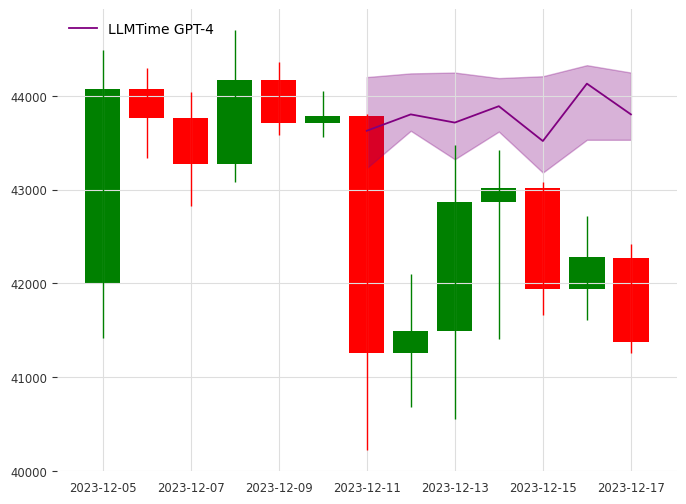

Data set : BTC_Daily_ohlc
from 2023-11-29 to 2023-01-01
training on 12 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.47s/it]

targets [41252.79968239 41491.14066286 42870.06425447 43022.65724186
 41939.53711693 42277.12350777 41373.37649145]
median date
2023-12-11 09:00:00    43746.718635
2023-12-12 09:00:00    43726.914779
2023-12-13 09:00:00    43726.914779
2023-12-14 09:00:00    43766.522491
2023-12-15 09:00:00    43786.326348
2023-12-16 09:00:00    43766.522491
2023-12-17 09:00:00    43746.718635
dtype: float64
Raw list completion :
[['1104, 1102, 1101, 1100, 1098, 1096, 1095', '1107, 1111, 1119, 1129, 1143, 1161, 1183, ', '1104, 1106, 1105, 1107, 1106, 1108, 1107, ', '1103, 1104, 1102, 1103', '1104, 1103, 1116, 1104, 1106, 1105, 1104, ', '1141, 1151, 1167, 1206, 1233, 1248', '1102, 1104, 1103, 1105, 1102, 1104, 1103', '1104, 1096, 1098, 1093, 1095, 1094, 1086, ', '1100, 1102, 1104, 1106, 1108, 1110, 1112', '1101, 1099, 1103, 1102, 1104']]
Model :  LLMTime GPT-4
MAE :  1719.9913142766247
MAES :  3395362.6706633223
dic_error_median :  {'input_length': {6: {'Mae': 1752.6093494796753, 'Mse': 3472340.04330161

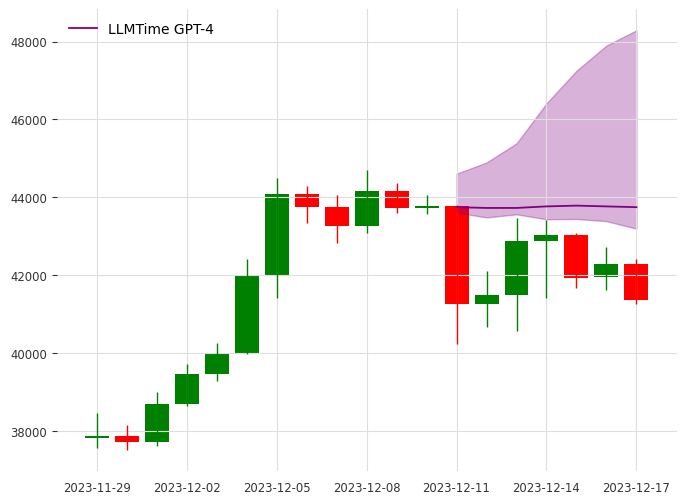

Data set : BTC_Daily_ohlc
from 2023-11-17 to 2023-01-01
training on 24 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.98s/it]

targets [41252.79968239 41491.14066286 42870.06425447 43022.65724186
 41939.53711693 42277.12350777 41373.37649145]
median date
2023-12-11 09:00:00    44258.898841
2023-12-12 09:00:00    44296.342918
2023-12-13 09:00:00    44427.397187
2023-12-14 09:00:00    44595.895533
2023-12-15 09:00:00    44858.004071
2023-12-16 09:00:00    45082.668532
2023-12-17 09:00:00    45232.444839
dtype: float64
Raw list completion :
[['1174, 1178, 1183, 1186, 1191, 1195, 1200, 120', '1203, 1229, 1243, 1297, 1353, 1344, 1331, 135', '1186, 1198, 1197, 1203, 1212, 1211, 1216, 122', '1183, 1192, 1187, 1191, 1199, 1208, 1207, 121', '1180, 1182, 1170, 1180, 1188, 1190, 1188, 119', '1182, 1183, 1189, 1192, 1195, 1201, 1205, 120', '1179, 1177, 1185, 1187, 1201, 1205, 1221, 123', '1187, 1198, 1211, 1227, 1246, 1257, 1271, 128', '1181, 1180, 1179, 1190, 1191, 1182, 1176, 119', '1171, 1176, 1183, 1190, 1196, 1202, 1208, 121']]
Model :  LLMTime GPT-4
MAE :  2646.421851956746
MAES :  7583871.02665644
dic_error_median 

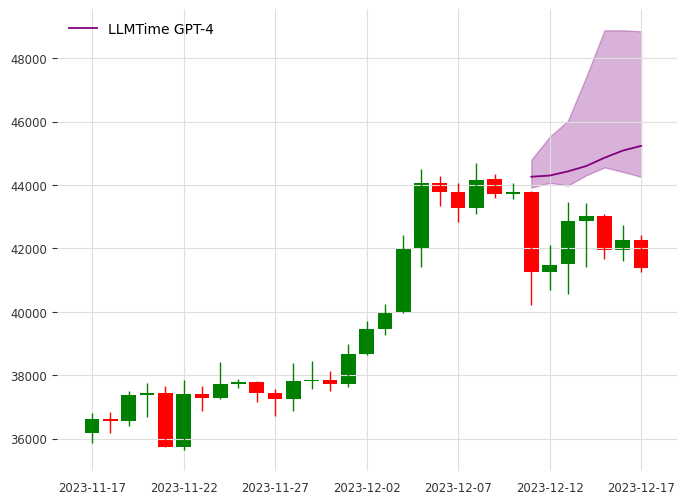

Data set : BTC_Daily_ohlc
from 2023-10-24 to 2023-01-01
training on 48 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]

targets [41252.79968239 41491.14066286 42870.06425447 43022.65724186
 41939.53711693 42277.12350777 41373.37649145]
median date
2023-12-11 09:00:00    43886.351037
2023-12-12 09:00:00    44134.396623
2023-12-13 09:00:00    44293.854499
2023-12-14 09:00:00    44347.007124
2023-12-15 09:00:00    44612.770251
2023-12-16 09:00:00    44931.686004
2023-12-17 09:00:00    45091.143880
dtype: float64
Raw list completion :
[['1238, 1254, 1256, 1251, 1256, 1263, 1265, 1269', '1240, 1247, 1250, 1242, 1246, 1249, 1229, 1244', '1238, 1252, 1249, 1256, 1271, 1293, 1308, 1345', '1242, 1240, 1245, 1251, 1281, 1298, 1293, 1291', '1247, 1242, 1249, 1256, 1264, 1267, 1274, 1281', '1234, 1256, 1284, 1289, 1302, 1321, 1335, 1358', '1238, 1241, 1245, 1250, 1257, 1268, 1272, 1280', '1234, 1243, 1241, 1244, 1256, 1252, 1255, 1266', '1244, 1247, 1256, 1253, 1260, 1265, 1272, 1280', '1228, 1241, 1250, 1248, 1247, 1279, 1272, 1274']]
Model :  LLMTime GPT-4
MAE :  2438.6443514485995
MAES :  6531163.981206031
dic_e

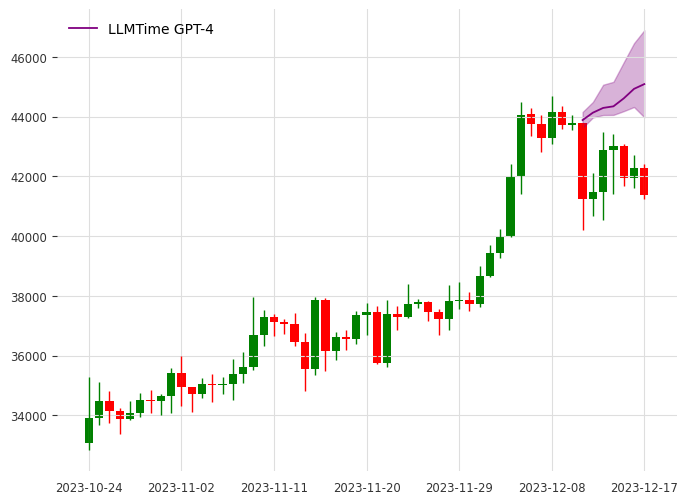

Data set : BTC_Daily_ohlc
from 2023-09-06 to 2023-01-01
training on 96 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.75s/it]

targets [41252.79968239 41491.14066286 42870.06425447 43022.65724186
 41939.53711693 42277.12350777 41373.37649145]
median date
2023-12-11 09:00:00    44063.265383
2023-12-12 09:00:00    44185.587835
2023-12-13 09:00:00    44511.781039
2023-12-14 09:00:00    44674.877642
2023-12-15 09:00:00    45041.844997
2023-12-16 09:00:00    45435.995119
2023-12-17 09:00:00    45884.510775
dtype: float64
Raw list completion :
[['1602, 1625, 1620, 1598, 1579, 1566, 1550, 1610', '1615, 1630, 1643, 1639, 1635, 1650, 1662, 1678', '1622, 1611, 1634, 1636, 1624, 1617, 1638, 1639', '1634, 1621, 1636, 1638, 1659, 1664, 1687, 1705', '1605, 1618, 1631, 1654, 1698, 1734, 1728, 1719', '1625, 1634, 1639, 1647, 1654, 1678, 1692, 1710', '1622, 1625, 1638, 1650, 1662, 1685, 1690, 1695', '1619, 1654, 1680, 1690, 1702, 1743, 1729, 1752', '1622, 1635, 1650, 1680, 1694, 1686, 1688, 1713', '1608, 1615, 1628, 1625, 1623, 1654, 1657, 1677']]
Model :  LLMTime GPT-4
MAE :  2795.880547310816
MAES :  8648135.11810236
dic_err

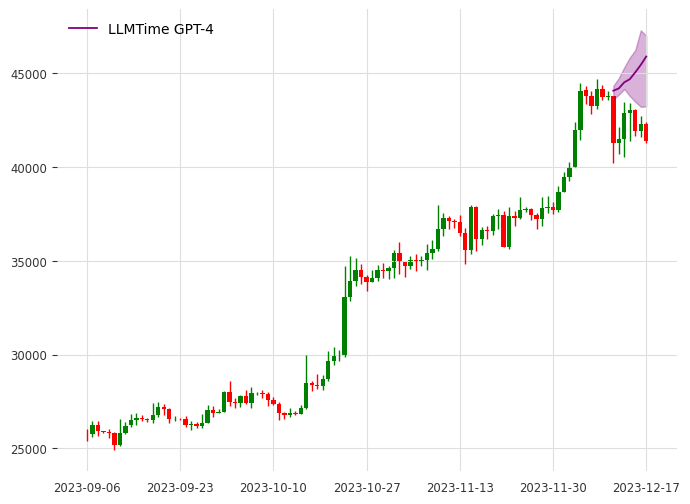

Data set : BTC_Daily_ohlc
from 2023-06-02 to 2023-01-01
training on 192 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.68s/it]

targets [41252.79968239 41491.14066286 42870.06425447 43022.65724186
 41939.53711693 42277.12350777 41373.37649145]
median date
2023-12-11 09:00:00    44018.499755
2023-12-12 09:00:00    43735.205702
2023-12-13 09:00:00    43883.597825
2023-12-14 09:00:00    43951.048790
2023-12-15 09:00:00    44018.499755
2023-12-16 09:00:00    44369.244773
2023-12-17 09:00:00    44328.774194
dtype: float64
Raw list completion :
[['1609, 1612, 1680, 1758, 1748, 1727, 1763, 1744', '1638, 1632, 1628, 1621, 1630, 1624, 1642, 1647', '1642, 1639, 1624, 1636, 1630, 1651, 1643, 1650', '1590, 1605, 1624, 1607, 1618, 1627, 1630, 1605', '1637, 1621, 1638, 1657, 1688, 1712, 1733, 1746', '1636, 1652, 1659, 1637, 1647, 1652, 1665, 1703', '1611, 1586, 1590, 1600, 1618, 1620, 1642, 1653', '1626, 1620, 1621, 1619, 1632, 1625, 1620, 1628', '1657, 1650, 1655, 1678, 1675, 1702, 1730, 1725', '1616, 1604, 1622, 1615, 1618, 1637, 1625, 1632']]
Model :  LLMTime GPT-4
MAE :  2011.1674047301317
MAES :  4572502.651875532
dic_e

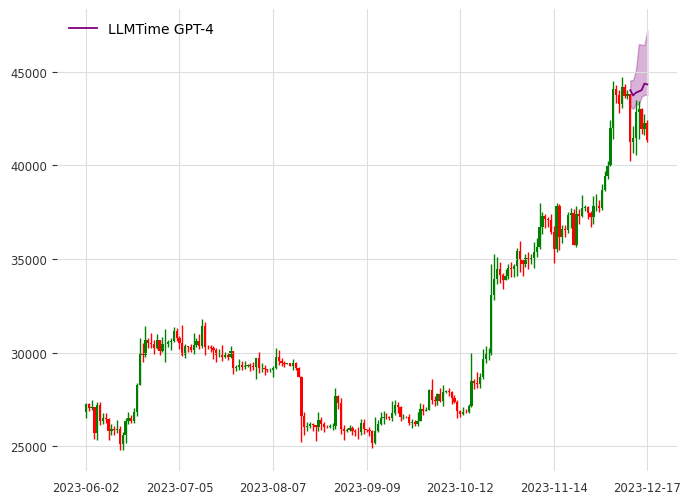

Two pickle files have been created one with MSE/MAE among all samples and the second with MSE/MAE among median only
The path for the pickle file are the following : 
pickle/dic_error_classic_2023-12-18_median.pkl
Data set : BTC_Daily_ohlc
from 2023-12-11 to 2023-01-01
training on 6 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.64s/it]

targets [41373.37649145 42657.42954629 42275.04228897 43668.73419165
 43862.36603114 43970.2624174  43703.51826148]
median date
2023-12-17 09:00:00    42883.368379
2023-12-18 09:00:00    43237.948759
2023-12-19 09:00:00    42612.218676
2023-12-20 09:00:00    42945.941387
2023-12-21 09:00:00    42945.941387
2023-12-22 09:00:00    42945.941387
2023-12-23 09:00:00    42945.941387
dtype: float64
Raw list completion :
[['1037, 1039, 1021, 1029', '1023, 1030', '1045, 1051', '1019, 1052, 1056, 1030, 1038', '1051, 1055, 1031, 1039', '1022, 1026, 1000, 1008, 1017, 1021, 995,', '1041, 1047, 1021, 1029', '1029, 1033, 1007, 1015', '1022, 1026, 1000, 1008, 1017, 1021, 995,', '1026, 1032, 1006, 1014']]
Model :  LLMTime GPT-4
MAE :  835.5432629395125
MAES :  816597.9760756426
dic_error_median :  {'input_length': {6: {'Mae': 835.5432629395125, 'Mse': 816597.9760756426}, 12: {'Mae': None, 'Mse': None}, 24: {'Mae': None, 'Mse': None}, 48: {'Mae': None, 'Mse': None}, 96: {'Mae': None, 'Mse': None}, 192: 

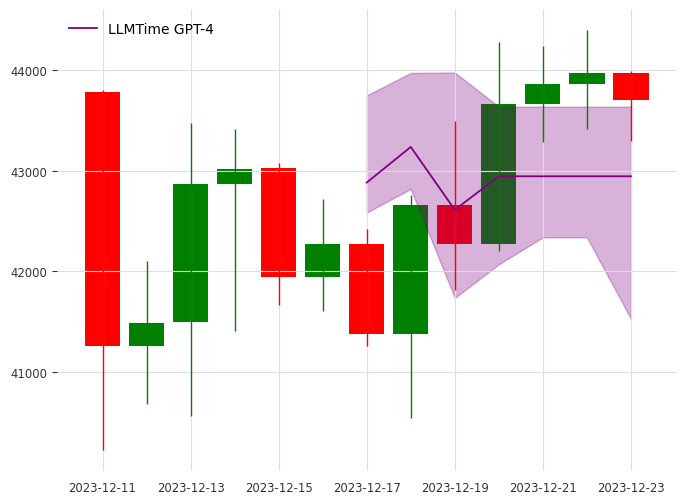

Data set : BTC_Daily_ohlc
from 2023-12-05 to 2023-01-01
training on 12 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.58s/it]

targets [41373.37649145 42657.42954629 42275.04228897 43668.73419165
 43862.36603114 43970.2624174  43703.51826148]
median date
2023-12-17 09:00:00    42646.053258
2023-12-18 09:00:00    42879.555789
2023-12-19 09:00:00    42582.370749
2023-12-20 09:00:00    42497.460738
2023-12-21 09:00:00    42582.370749
2023-12-22 09:00:00    42709.735766
2023-12-23 09:00:00    42709.735766
dtype: float64
Raw list completion :
[['1000, 1008, 1016, 1024, 1032, 1040, 1048, ', '1017, 1021, 998, 1003, 1026, 1028, 1002, 100', '1007, 1011, 985, 993, 1005, 1009, 983, 991', '989, 1009, 1011, 991, 1001, 993, 1013, 1015', '1009, 1015, 1003, 1005, 999, 1007', '997, 1010, 1002, 998, 960, 965, 994, 999, 973,', '1017, 1023, 1011, 1021, 1030, 1037, 1026, ', '1003, 1007, 981, 989, 997, 1001, 975, 983, 991', '997, 1009, 1011, 993, 1001, 1003, 1015, 997,', '1005, 1007, 997, 1004']]
Model :  LLMTime GPT-4
MAE :  929.6727645381054
MAES :  1050042.5020369033
dic_error_median :  {'input_length': {6: {'Mae': 835.543262939

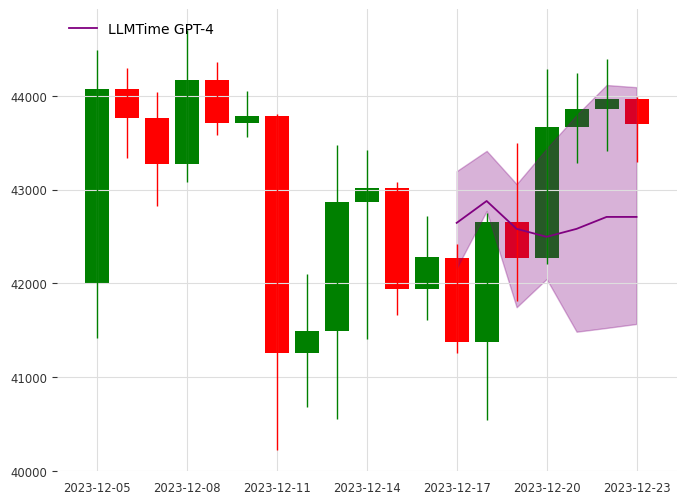

Data set : BTC_Daily_ohlc
from 2023-11-23 to 2023-01-01
training on 24 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]

targets [41373.37649145 42657.42954629 42275.04228897 43668.73419165
 43862.36603114 43970.2624174  43703.51826148]
median date
2023-12-17 09:00:00    42564.074775
2023-12-18 09:00:00    42866.887224
2023-12-19 09:00:00    42847.961446
2023-12-20 09:00:00    43075.070782
2023-12-21 09:00:00    43434.660565
2023-12-22 09:00:00    43737.473013
2023-12-23 09:00:00    43775.324569
dtype: float64
Raw list completion :
[['1124, 1128, 1132, 1136, 1140, 1144, 1148, 115', '1115, 1132, 1126, 1134, 1070, 1078, 1115, 112', '1133, 1132, 1124, 1129, 1146, 1152, 1149, 115', '1138, 1145, 1152, 1159, 1166, 1173, 1180, 118', '1130, 1139, 1147, 1152, 1156, 1160, 1163, 116', '1110, 1109, 1120, 1123, 1128, 1132, 1139, 114', '1121, 1135, 1148, 1161, 1176, 1189, 1205, 122', '1124, 1132, 1140, 1148, 1156, 1164, 1172, 118', '1119, 1124, 1131, 1139, 1148, 1158, 1169, 118', '1128, 1119, 1099, 1085, 1098, 1079, 1078, 108']]
Model :  LLMTime GPT-4
MAE :  471.29138664629653
MAES :  340655.2207350267
dic_error_media

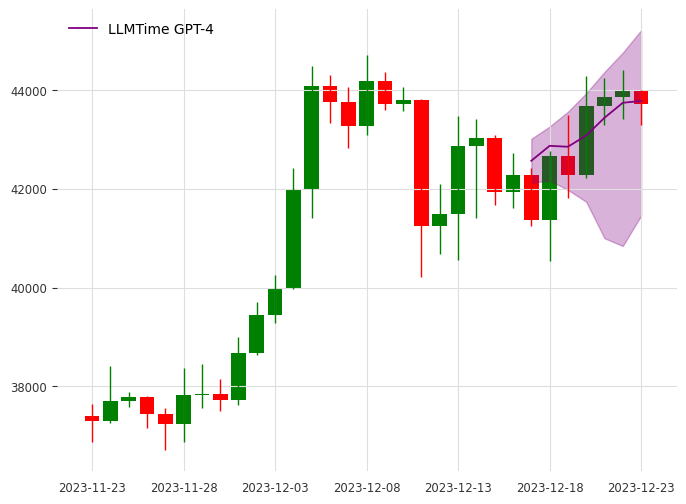

Data set : BTC_Daily_ohlc
from 2023-10-30 to 2023-01-01
training on 48 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.72s/it]

targets [41373.37649145 42657.42954629 42275.04228897 43668.73419165
 43862.36603114 43970.2624174  43703.51826148]
median date
2023-12-17 09:00:00    42406.860835
2023-12-18 09:00:00    42516.581044
2023-12-19 09:00:00    43211.475702
2023-12-20 09:00:00    43174.902299
2023-12-21 09:00:00    43522.349628
2023-12-22 09:00:00    43723.503345
2023-12-23 09:00:00    43961.230465
dtype: float64
Raw list completion :
[['1159, 1162, 1167, 1181, 1188, 1192, 1201, 1206', '1147, 1158, 1170, 1185, 1197, 1201, 1208, 1220', '1178, 1165, 1208, 1216, 1237, 1224, 1233, 1203', '1159, 1138, 1181, 1175, 1193, 1195, 1138, 1171', '1159, 1158, 1181, 1171, 1191, 1195, 1196, 1202', '1159, 1167, 1182, 1179, 1183, 1185, 1186, 1189', '1158, 1201, 1193, 1188, 1212, 1200, 1202, 1132', '1168, 1173, 1184, 1181, 1183, 1207, 1221, 1208', '1158, 1162, 1165, 1173, 1181, 1192, 1204, 1215', '1159, 1162, 1143, 1148, 1167, 1171, 1155, 1161']]
Model :  LLMTime GPT-4
MAE :  492.7265471883584
MAES :  350231.77688993985
dic_e

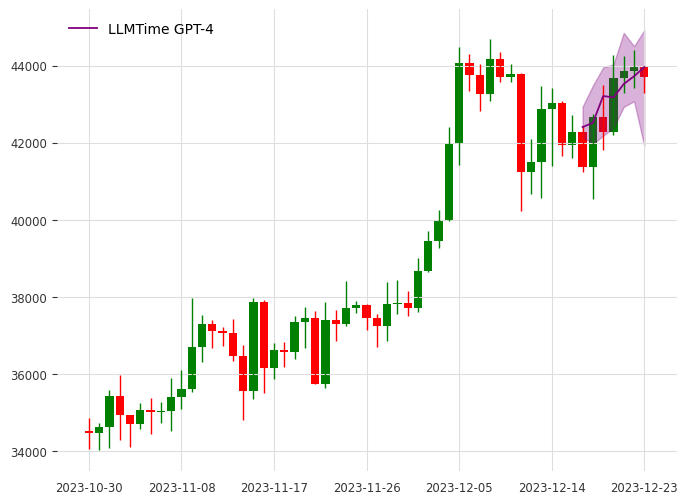

Data set : BTC_Daily_ohlc
from 2023-09-12 to 2023-01-01
training on 96 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


targets [41373.37649145 42657.42954629 42275.04228897 43668.73419165
 43862.36603114 43970.2624174  43703.51826148]
median date
2023-12-17 09:00:00    42440.568027
2023-12-18 09:00:00    42606.675926
2023-12-19 09:00:00    42925.049397
2023-12-20 09:00:00    43257.265194
2023-12-21 09:00:00    43561.796341
2023-12-22 09:00:00    43838.642838
2023-12-23 09:00:00    44267.754909
dtype: float64
Raw list completion :
[['1543, 1591, 1581, 1585, 1605, 1637, 1663, 1666', '1532, 1553, 1569, 1568, 1576, 1593, 1602, 1607', '1533, 1541, 1532, 1528, 1538, 1567, 1561, 1558', '1530, 1529, 1542, 1564, 1570, 1579, 1595, 1605', '1548, 1501, 1532, 1534, 1542, 1587, 1608, 1615', '1539, 1541, 1523, 1528, 1540, 1545, 1555, 1561', '1532, 1545, 1568, 1589, 1591, 1588, 1604, 1623', '1542, 1521, 1582, 1598, 1587, 1564, 1571, 1568', '1523, 1527, 1530, 1535, 1561, 1563, 1580, 1587', '1521, 1536, 1558, 1560, 1605, 1643, 1648, 1632']]
Model :  LLMTime GPT-4
MAE :  453.6924541798549
MAES :  308474.0753604575
dic_er

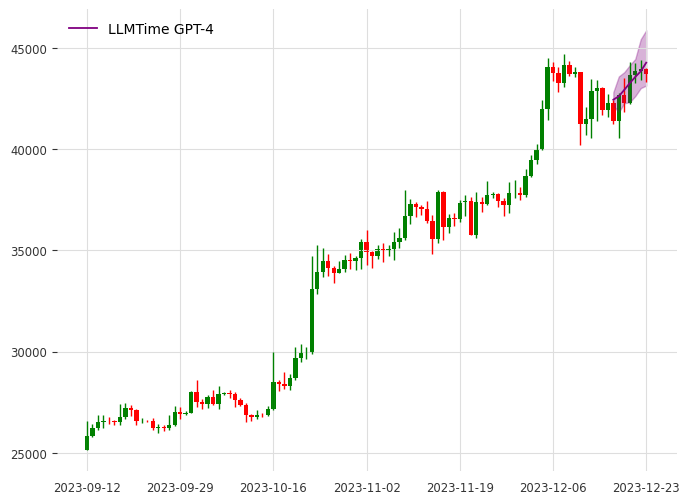

Data set : BTC_Daily_ohlc
from 2023-06-08 to 2023-01-01
training on 192 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:02<00:00,  2.24s/it]

targets [41373.37649145 42657.42954629 42275.04228897 43668.73419165
 43862.36603114 43970.2624174  43703.51826148]
median date
2023-12-17 09:00:00    42139.345881
2023-12-18 09:00:00    41976.540939
2023-12-19 09:00:00    42180.047116
2023-12-20 09:00:00    42288.583745
2023-12-21 09:00:00    42546.358236
2023-12-22 09:00:00    42695.596100
2023-12-23 09:00:00    42736.297336
dtype: float64
Raw list completion :
[['1545, 1543, 1561, 1556, 1580, 1603, 1608, 1625', '1566, 1564, 1567, 1572, 1574, 1576, 1581, 1587', '1549, 1545, 1532, 1550, 1555, 1560, 1567, 1562', '1575, 1580, 1583, 1600, 1625, 1632, 1630, 1638', '1520, 1538, 1545, 1560, 1577, 1571, 1568, 1580', '1556, 1557, 1560, 1562, 1561, 1564, 1568, 1571', '1556, 1542, 1527, 1543, 1539, 1544, 1558, 1574', '1559, 1564, 1530, 1515, 1551, 1565, 1597, 1614', '1542, 1548, 1592, 1615, 1608, 1599, 1621, 1628', '1546, 1545, 1548, 1546, 1553, 1575, 1561, 1562']]
Model :  LLMTime GPT-4
MAE :  925.6998077769707
MAES :  1036617.8280370301
dic_e

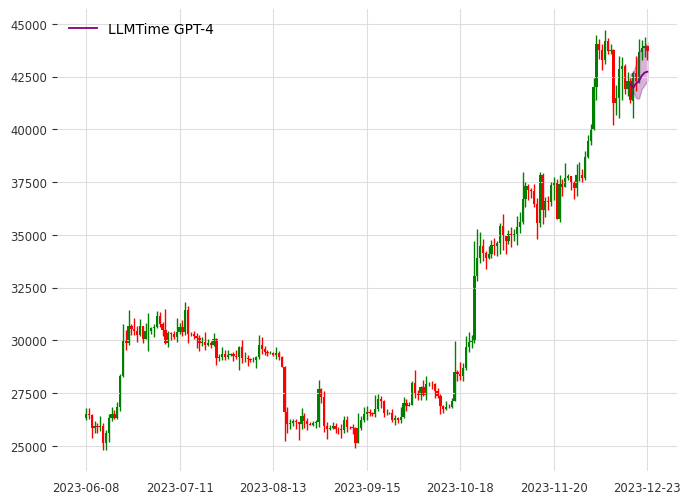

Two pickle files have been created one with MSE/MAE among all samples and the second with MSE/MAE among median only
The path for the pickle file are the following : 
pickle/dic_error_classic_2023-12-24_median.pkl
Data set : BTC_Daily_ohlc
from 2023-12-17 to 2023-01-01
training on 6 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.77s/it]

targets [43703.51826148 42992.98706056 43576.56218605 42508.99094461
 43431.19420403 42564.5023179  42067.25520307]
median date
2023-12-23 09:00:00    44462.149006
2023-12-24 09:00:00    44823.112011
2023-12-25 09:00:00    45014.210073
2023-12-26 09:00:00    45014.210073
2023-12-27 09:00:00    45162.841898
2023-12-28 09:00:00    45269.007488
2023-12-29 09:00:00    45269.007488
dtype: float64
Raw list completion :
[['1064, 1072, 1077', '1056, 1060, 1063', '1045, 1058, 1081', '1042, 1044', '1041, 1045, 1049', '1042, 1049, 1056', '1055, 1063, 1068', '1056, 1070, 1074', '1048, 1052, 1056', '1039, 1045, 1050, 1056, 1063, 1069, 1075']]
Model :  LLMTime GPT-4
MAE :  2024.2182656113728
MAES :  4690285.987868848
dic_error_median :  {'input_length': {6: {'Mae': 2024.2182656113728, 'Mse': 4690285.987868848}, 12: {'Mae': None, 'Mse': None}, 24: {'Mae': None, 'Mse': None}, 48: {'Mae': None, 'Mse': None}, 96: {'Mae': None, 'Mse': None}, 192: {'Mae': None, 'Mse': None}}}
Sequence lenght :  6
Raw scal

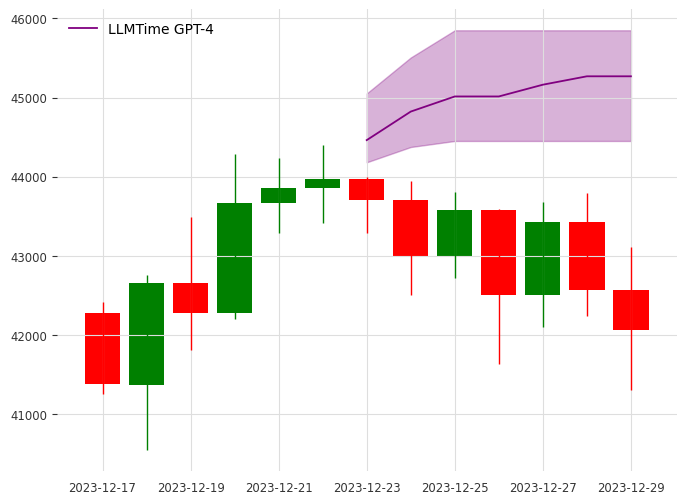

Data set : BTC_Daily_ohlc
from 2023-12-11 to 2023-01-01
training on 12 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:02<00:00,  2.01s/it]

targets [43703.51826148 42992.98706056 43576.56218605 42508.99094461
 43431.19420403 42564.5023179  42067.25520307]
median date
2023-12-23 09:00:00    43133.233574
2023-12-24 09:00:00    43658.735932
2023-12-25 09:00:00    42859.972348
2023-12-26 09:00:00    44121.178008
2023-12-27 09:00:00    43742.816310
2023-12-28 09:00:00    45130.142536
2023-12-29 09:00:00    45319.323385
dtype: float64
Raw list completion :
[['1023, 1028, 997, 1031, 1014, 1055, 1059, 100', '1058, 1068, 1047, 1077, 1068, 1101, 1106, ', '1026, 1070, 1061, 1094, 1099, 1101, 1082, ', '1020, 1028, 1007, 1037, 1028, 1061, 1066, ', '1027, 1035, 1014, 1044, 1035, 1068, 1073, ', '1021, 1041, 1024, 1054, 1045, 1078, 1083, ', '1053, 1042, 1072, 1063, 1096, 1101, 1103, ', '1025, 1033, 1012, 1042, 1033, 1066, 1071, ', '1019, 1027, 1006, 1036, 1027, 1060, 1065, ', '1066, 1064, 1083, 1087, 1081, 1082, 1109, ']]
Model :  LLMTime GPT-4
MAE :  1384.877280821425
MAES :  3019522.832782867
dic_error_median :  {'input_length': {6: {'M

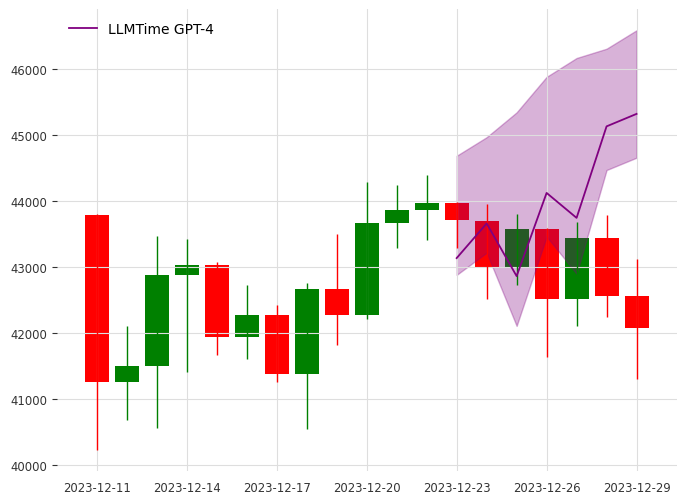

Data set : BTC_Daily_ohlc
from 2023-11-29 to 2023-01-01
training on 24 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:02<00:00,  2.48s/it]

targets [43703.51826148 42992.98706056 43576.56218605 42508.99094461
 43431.19420403 42564.5023179  42067.25520307]
median date
2023-12-23 09:00:00    44196.262604
2023-12-24 09:00:00    44051.084829
2023-12-25 09:00:00    44258.481650
2023-12-26 09:00:00    44258.481650
2023-12-27 09:00:00    44341.440379
2023-12-28 09:00:00    44797.713385
2023-12-29 09:00:00    44196.262604
dtype: float64
Raw list completion :
[['1065, 1064, 1083, 1091, 1099, 1133, 1172, 116', '1049, 1055, 1088, 1092, 1066, 1074, 1052, 108', '1065, 1070, 1075, 1080, 1085, 1090, 1095, 110', '1067, 1059, 1051, 1064, 1066, 1055, 1034, 104', '1068, 1073, 1071, 1069, 1080, 1085, 1078, 108', '1045, 1053, 1040, 1062, 1056, 1042, 1047, 103', '1065, 1067, 1062, 1054, 1014, 1020, 1035, 104', '1067, 1045, 1053, 1061, 1066, 1066, 1050, 105', '1056, 1045, 1050, 1047, 1071, 1090, 1102, 115', '1063, 1071, 1096, 1089, 1112, 1131, 1143, 119']]
Model :  LLMTime GPT-4
MAE :  1322.1024176133785
MAES :  2176650.29165527
dic_error_median

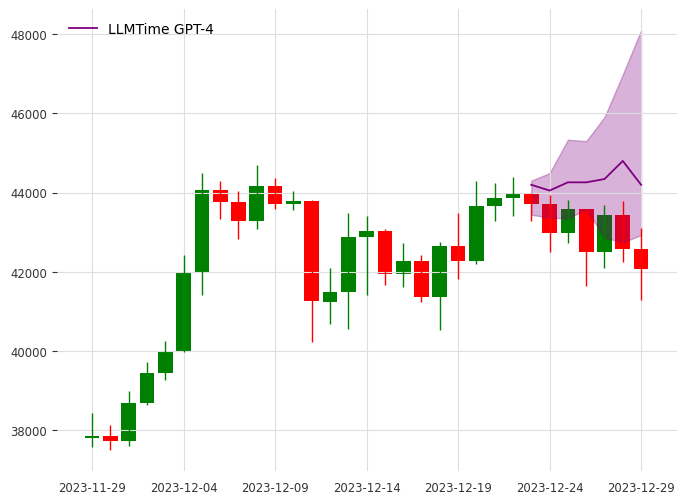

Data set : BTC_Daily_ohlc
from 2023-11-05 to 2023-01-01
training on 48 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.41s/it]

targets [43703.51826148 42992.98706056 43576.56218605 42508.99094461
 43431.19420403 42564.5023179  42067.25520307]
median date
2023-12-23 09:00:00    44120.371147
2023-12-24 09:00:00    44418.733758
2023-12-25 09:00:00    44344.143105
2023-12-26 09:00:00    44866.277675
2023-12-27 09:00:00    44717.096369
2023-12-28 09:00:00    45295.173929
2023-12-29 09:00:00    45369.764581
dtype: float64
Raw list completion :
[['1195, 1197, 1187, 1209, 1199, 1181, 1194, 1207', '1168, 1189, 1182, 1216, 1236, 1223, 1247, 1240', '1189, 1201, 1207, 1213, 1219, 1225, 1233, 1237', '1183, 1189, 1194, 1192, 1168, 1174, 1139, 1165', '1182, 1192, 1190, 1206, 1215, 1221, 1222, 1234', '1181, 1183, 1185, 1187, 1189, 1191, 1193, 1195', '1187, 1196, 1192, 1213, 1221, 1226, 1233, 1244', '1161, 1183, 1179, 1192, 1194, 1185, 1179, 1195', '1195, 1203, 1198, 1199, 1197, 1220, 1231, 1226', '1171, 1177, 1187, 1189, 1198, 1208, 1210, 1220']]
Model :  LLMTime GPT-4
MAE :  1755.2214837702777
MAES :  4052740.169744628
dic_e

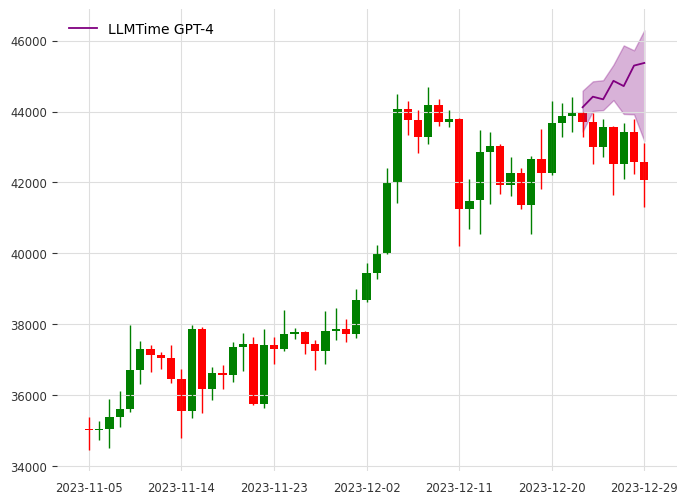

Data set : BTC_Daily_ohlc
from 2023-09-18 to 2023-01-01
training on 96 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:02<00:00,  2.31s/it]

targets [43703.51826148 42992.98706056 43576.56218605 42508.99094461
 43431.19420403 42564.5023179  42067.25520307]
median date
2023-12-23 09:00:00    43955.524843
2023-12-24 09:00:00    44168.212866
2023-12-25 09:00:00    44111.496060
2023-12-26 09:00:00    44168.212866
2023-12-27 09:00:00    44295.825680
2023-12-28 09:00:00    44607.768115
2023-12-29 09:00:00    44721.201727
dtype: float64
Raw list completion :
[['1552, 1564, 1567, 1571, 1573, 1577, 1580, 1584', '1524, 1543, 1517, 1527, 1537, 1576, 1580, 1587', '1564, 1566, 1558, 1554, 1553, 1555, 1565, 1570', '1540, 1562, 1549, 1558, 1551, 1564, 1555, 1558', '1538, 1560, 1569, 1607, 1626, 1607, 1612, 1635', '1551, 1557, 1562, 1563, 1566, 1569, 1573, 1576', '1548, 1544, 1552, 1556, 1560, 1564, 1568, 1572', '1558, 1534, 1552, 1546, 1557, 1578, 1596, 1604', '1556, 1543, 1540, 1551, 1563, 1567, 1560, 1590', '1546, 1557, 1560, 1562, 1578, 1596, 1592, 1605']]
Model :  LLMTime GPT-4
MAE :  1311.890282781275
MAES :  2349969.929168627
dic_er

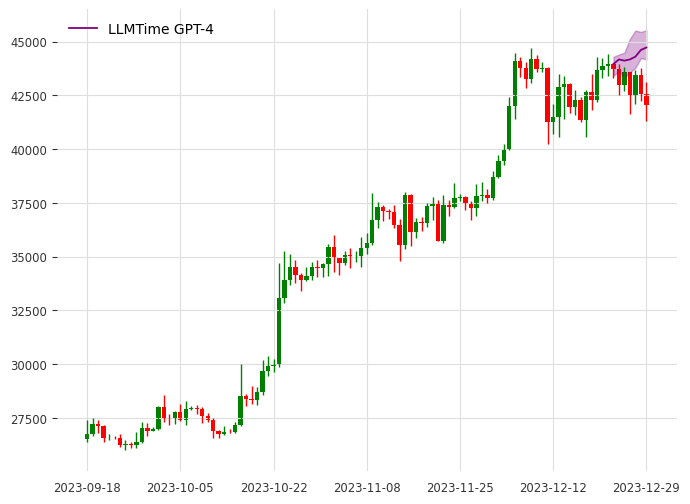

Data set : BTC_Daily_ohlc
from 2023-06-14 to 2023-01-01
training on 192 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]

targets [43703.51826148 42992.98706056 43576.56218605 42508.99094461
 43431.19420403 42564.5023179  42067.25520307]
median date
2023-12-23 09:00:00    43970.566298
2023-12-24 09:00:00    43929.395355
2023-12-25 09:00:00    44052.908182
2023-12-26 09:00:00    44176.421009
2023-12-27 09:00:00    44121.526419
2023-12-28 09:00:00    44080.355477
2023-12-29 09:00:00    44176.421009
dtype: float64
Raw list completion :
[['1609, 1602, 1608, 1610, 1610, 1623, 1626, 1638', '1595, 1612, 1614, 1620, 1625, 1630, 1635, 1640', '1597, 1598, 1604, 1609, 1607, 1608, 1605, 1609', '1594, 1609, 1605, 1602, 1604, 1597, 1601, 1610', '1605, 1595, 1601, 1609, 1605, 1599, 1606, 1612', '1599, 1581, 1586, 1574, 1591, 1589, 1594, 1596', '1612, 1628, 1633, 1629, 1634, 1642, 1651, 1658', '1604, 1572, 1570, 1574, 1592, 1603, 1612, 1620', '1599, 1591, 1597, 1603, 1607, 1598, 1599, 1602', '1620, 1639, 1627, 1654, 1682, 1659, 1625, 1583']]
Model :  LLMTime GPT-4
MAE :  1094.6547958996732
MAES :  1596907.6340721233
dic_

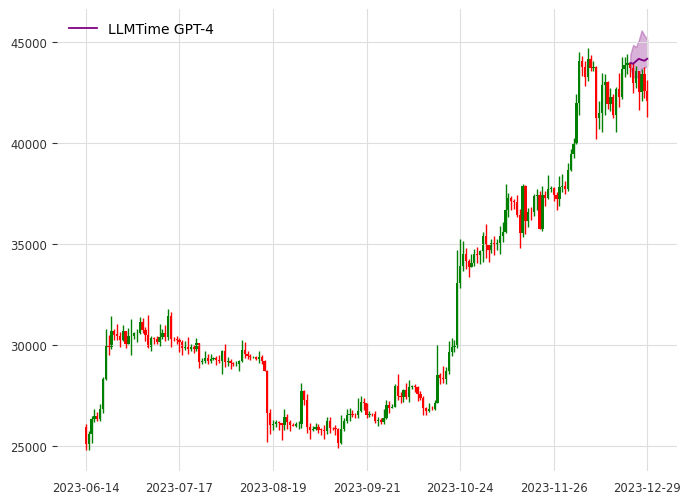

Two pickle files have been created one with MSE/MAE among all samples and the second with MSE/MAE among median only
The path for the pickle file are the following : 
pickle/dic_error_classic_2023-12-30_median.pkl
Data set : BTC_Daily_ohlc
from 2023-12-23 to 2023-01-01
training on 6 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:02<00:00,  2.02s/it]

targets [42067.25520307 42140.5815813  42282.34870028 44179.97243995
 44948.22955209 42846.15398732 44153.09862627]
median date
2023-12-29 09:00:00    43313.478998
2023-12-30 09:00:00    42586.240338
2023-12-31 09:00:00    43185.142764
2024-01-01 09:00:00    42629.019083
2024-01-02 09:00:00    43014.027785
2024-01-03 09:00:00    42671.797828
2024-01-04 09:00:00    42671.797828
dtype: float64
Raw list completion :
[['1012, 995, 1009, 996, 1004, 997', '1012, 995, 1009, 996', '1012, 995', '1012, 995, 1009, 996, 1006, 997, 1003, 998', '1012, 995, 1009, 996, 1004, 997, 999, 998', '1012, 995, 1009, 996, 1006, 997', '1012, 995, 1009, 996, 1006, 997', '1012, 995', '1012, 995, 1009, 996, 1006, 997', '1014, 995, 1013, 996, 1012, 997']]
Model :  LLMTime GPT-4
MAE :  1105.0698139808997
MAES :  1562566.7876954596
dic_error_median :  {'input_length': {6: {'Mae': 1105.0698139808997, 'Mse': 1562566.7876954596}, 12: {'Mae': None, 'Mse': None}, 24: {'Mae': None, 'Mse': None}, 48: {'Mae': None, 'Mse': No

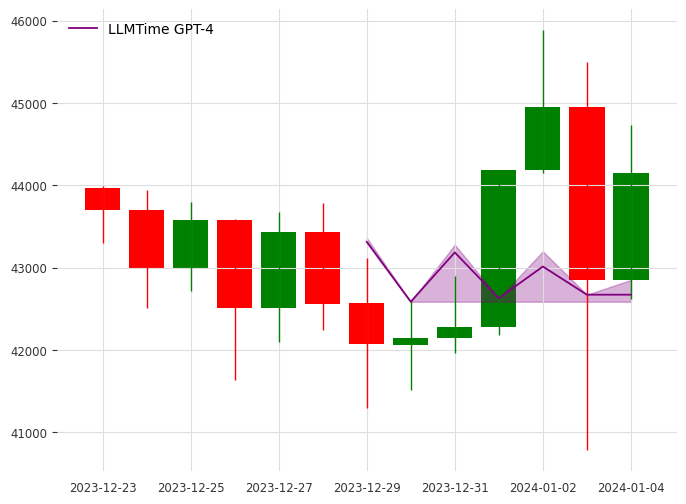

Data set : BTC_Daily_ohlc
from 2023-12-17 to 2023-01-01
training on 12 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:02<00:00,  2.12s/it]

targets [42067.25520307 42140.5815813  42282.34870028 44179.97243995
 44948.22955209 42846.15398732 44153.09862627]
median date
2023-12-29 09:00:00    43231.266194
2023-12-30 09:00:00    42613.676677
2023-12-31 09:00:00    43060.896672
2024-01-01 09:00:00    42656.269057
2024-01-02 09:00:00    42869.230960
2024-01-03 09:00:00    42698.861438
2024-01-04 09:00:00    42741.453818
dtype: float64
Raw list completion :
[['981, 1018, 991, 1020, 993, 1022, 995, 1024, ', '1006, 981, 1005, 972, 990, 978, 977, 988, 964,', '1016, 1000, 1013, 1001, 1010, 1002, 1007, ', '1020, 1005, 1022, 1008, 1024, 1011, 1026, ', '1015, 1000, 1011, 1001, 1007, 1002, 1003, ', '1012, 990, 1005, 990, 996, 981, 990, 965, 975,', '1014, 1001, 1010, 1002, 1005, 1004, 1011, ', '1020, 1007, 1016, 1004, 1012, 1002, 1010, ', '1015, 1000, 1011, 1001, 1007, 1002, 1003, ', '1003, 982, 1005, 976, 998, 974, 991, 971, 986']]
Model :  LLMTime GPT-4
MAE :  1082.4704843755349
MAES :  1549031.5436367367
dic_error_median :  {'input_len

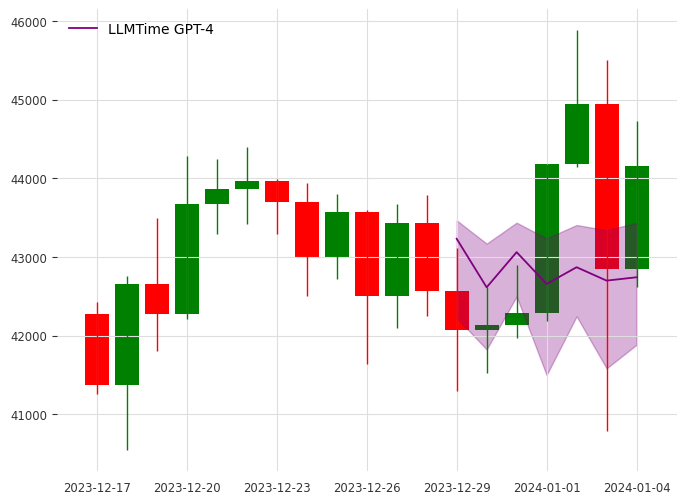

Data set : BTC_Daily_ohlc
from 2023-12-05 to 2023-01-01
training on 24 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.66s/it]

targets [42067.25520307 42140.5815813  42282.34870028 44179.97243995
 44948.22955209 42846.15398732 44153.09862627]
median date
2023-12-29 09:00:00    42878.143314
2023-12-30 09:00:00    42899.422790
2023-12-31 09:00:00    43516.527582
2024-01-01 09:00:00    43218.614924
2024-01-02 09:00:00    43112.217546
2024-01-03 09:00:00    42558.951181
2024-01-04 09:00:00    43090.938070
dtype: float64
Raw list completion :
[['1004, 1030, 1028, 1027, 1033, 972, 979, 1003,', '994, 996, 990, 998, 1005, 996, 1000, 974, 1012,', '1015, 1008, 1010, 1005, 1023, 1018, 1020, 101', '1005, 1012, 1014, 1017, 998, 1011, 1009, 992,', '1009, 993, 1012, 1008, 1015, 975, 990, 1010, ', '1005, 1007, 1023, 1015, 1010, 1003, 1015, 101', '1023, 1005, 1024, 1008, 1029, 1012, 1035, 101', '1018, 1015, 1026, 1015, 1008, 996, 1017, 1007', '1015, 998, 1022, 1018, 1002, 995, 1010, 1005,', '1003, 1018, 1022, 1038, 1043, 1028, 1014, 102']]
Model :  LLMTime GPT-4
MAE :  992.9487266932992
MAES :  1180342.2686993794
dic_error_med

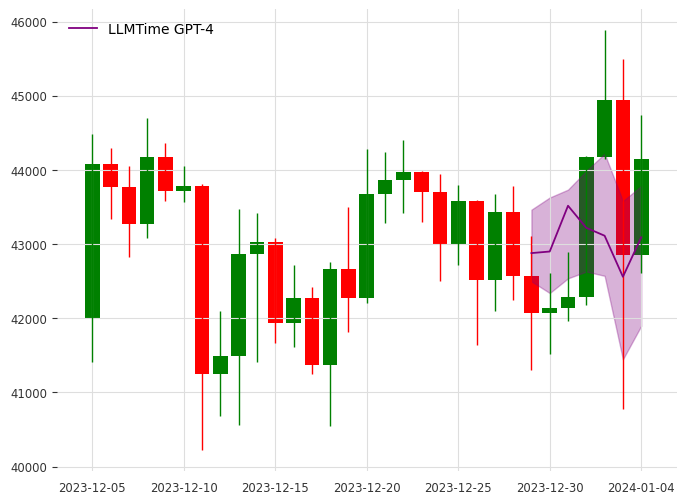

Data set : BTC_Daily_ohlc
from 2023-11-11 to 2023-01-01
training on 48 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:02<00:00,  2.08s/it]

targets [42067.25520307 42140.5815813  42282.34870028 44179.97243995
 44948.22955209 42846.15398732 44153.09862627]
median date
2023-12-29 09:00:00    43391.932255
2023-12-30 09:00:00    42995.917228
2023-12-31 09:00:00    43297.642962
2024-01-01 09:00:00    43127.922237
2024-01-02 09:00:00    43354.216538
2024-01-03 09:00:00    42845.054360
2024-01-04 09:00:00    43146.780095
dtype: float64
Raw list completion :
[['1150, 1139, 1148, 1127, 1130, 1132, 1145, 1160', '1159, 1140, 1167, 1165, 1171, 1169, 1142, 1167', '1143, 1121, 1147, 1114, 1136, 1105, 1131, 1108', '1167, 1171, 1176, 1164, 1156, 1173, 1160, 1179', '1143, 1136, 1139, 1120, 1135, 1120, 1134, 1115', '1150, 1155, 1142, 1151, 1154, 1148, 1139, 1152', '1138, 1139, 1170, 1165, 1172, 1153, 1187, 1188', '1154, 1143, 1128, 1121, 1155, 1136, 1154, 1153', '1135, 1136, 1148, 1153, 1144, 1135, 1170, 1149', '1155, 1146, 1140, 1135, 1118, 1123, 1107, 1136']]
Model :  LLMTime GPT-4
MAE :  978.3983337415827
MAES :  1168222.3018974846
dic_e

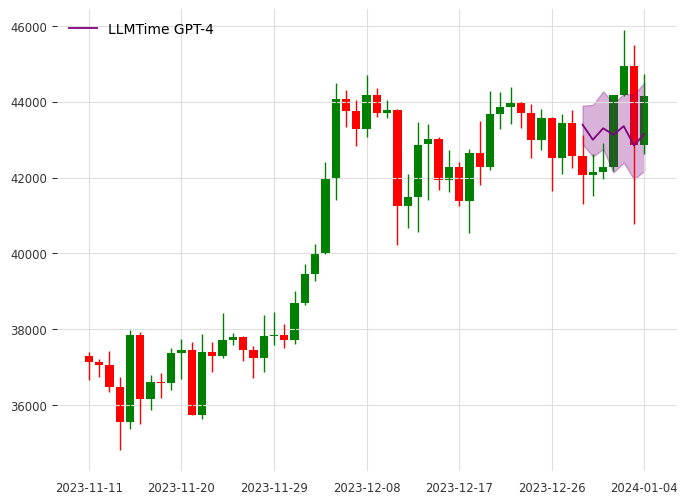

Data set : BTC_Daily_ohlc
from 2023-09-24 to 2023-01-01
training on 96 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.60s/it]

targets [42067.25520307 42140.5815813  42282.34870028 44179.97243995
 44948.22955209 42846.15398732 44153.09862627]
median date
2023-12-29 09:00:00    43150.877150
2023-12-30 09:00:00    43024.751093
2023-12-31 09:00:00    43308.534721
2024-01-01 09:00:00    43261.237450
2024-01-02 09:00:00    43702.678648
2024-01-03 09:00:00    44065.291061
2024-01-04 09:00:00    44159.885604
dtype: float64
Raw list completion :
[['1367, 1356, 1338, 1327, 1361, 1372, 1350, 1365', '1367, 1354, 1332, 1328, 1325, 1356, 1382, 1378', '1368, 1361, 1356, 1332, 1341, 1379, 1383, 1390', '1380, 1388, 1389, 1392, 1384, 1403, 1431, 1450', '1368, 1362, 1389, 1392, 1400, 1398, 1403, 1434', '1377, 1375, 1384, 1381, 1392, 1400, 1402, 1401', '1370, 1356, 1335, 1331, 1344, 1327, 1319, 1316', '1341, 1398, 1401, 1394, 1398, 1410, 1426, 1451', '1357, 1366, 1365, 1362, 1387, 1396, 1398, 1403', '1369, 1373, 1381, 1385, 1389, 1405, 1411, 1423']]
Model :  LLMTime GPT-4
MAE :  912.0267750463505
MAES :  984408.9005396423
dic_er

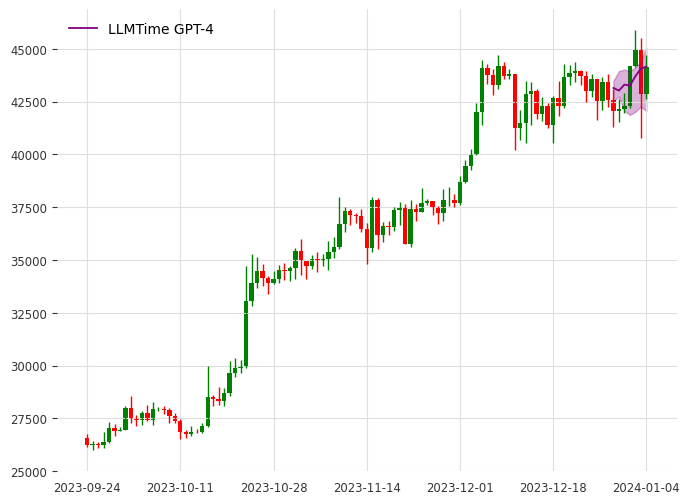

Data set : BTC_Daily_ohlc
from 2023-06-20 to 2023-01-01
training on 192 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.23s/it]


targets [42067.25520307 42140.5815813  42282.34870028 44179.97243995
 44948.22955209 42846.15398732 44153.09862627]
median date
2023-12-29 09:00:00    42635.505793
2023-12-30 09:00:00    42775.202732
2023-12-31 09:00:00    42872.990589
2024-01-01 09:00:00    42900.929977
2024-01-02 09:00:00    42998.717835
2024-01-03 09:00:00    42970.778447
2024-01-04 09:00:00    42900.929977
dtype: float64
Raw list completion :
[['1526, 1549, 1557, 1562, 1539, 1542, 1527, 1523', '1529, 1537, 1528, 1526, 1538, 1528, 1534, 1525', '1524, 1531, 1537, 1538, 1543, 1549, 1552, 1548', '1526, 1533, 1536, 1549, 1557, 1571, 1598, 1623', '1518, 1509, 1506, 1511, 1516, 1520, 1515, 1523', '1524, 1530, 1527, 1532, 1535, 1533, 1536, 1528', '1521, 1519, 1532, 1532, 1531, 1533, 1523, 1540', '1525, 1527, 1532, 1530, 1532, 1524, 1533, 1534', '1527, 1541, 1539, 1541, 1544, 1557, 1550, 1567', '1526, 1528, 1543, 1557, 1562, 1578, 1584, 1591']]
Model :  LLMTime GPT-4
MAE :  914.1229883895815
MAES :  1156359.1026691154
dic_e

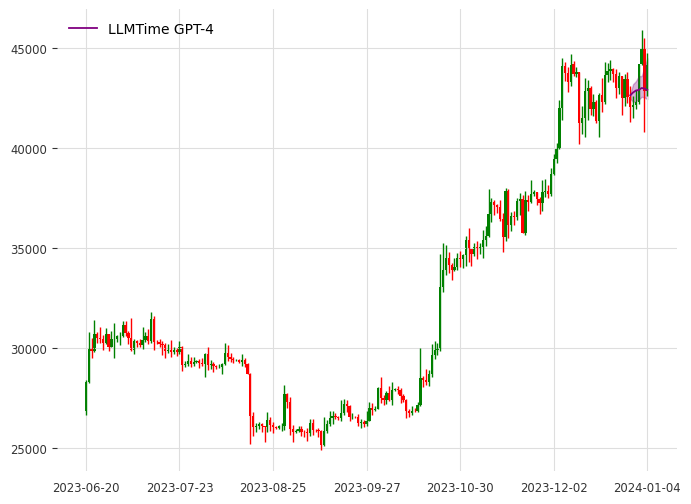

Two pickle files have been created one with MSE/MAE among all samples and the second with MSE/MAE among median only
The path for the pickle file are the following : 
pickle/dic_error_classic_2024-01-05_median.pkl
Data set : BTC_Daily_ohlc
from 2023-12-29 to 2023-01-01
training on 6 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.56s/it]

targets [44153.09862627 44147.50536139 43969.91882947 43930.07673449
 46953.13121524 46110.76341917 46655.15188279]
median date
2024-01-04 09:00:00    43287.857502
2024-01-05 09:00:00    44680.835852
2024-01-06 09:00:00    45039.633305
2024-01-07 09:00:00    43921.029479
2024-01-08 09:00:00    43667.760688
2024-01-09 09:00:00    44490.884258
2024-01-10 09:00:00    44870.787445
dtype: float64
Raw list completion :
[['1019, 1064, 1082, 1033, 1037, 1082, 1100', '998, 1030, 1051, 1007, 1002, 1016', '1060, 1105, 1123, 1074', '1040, 1062, 1051, 1096, 1114, 1065', '1026, 1091, 1109', '961, 986, 1029, 1078, 1017, 962, 980', '1036, 1054, 1005', '1027, 1078, 1096, 1047', '1024, 1053, 1071, 1022, 1031, 1060, 1078', '975, 1044, 1062, 1013, 972, 1042, 1060, ']]
Model :  LLMTime GPT-4
MAE :  1309.563924539037
MAES :  2682725.5673370534
dic_error_median :  {'input_length': {6: {'Mae': 1309.563924539037, 'Mse': 2682725.5673370534}, 12: {'Mae': None, 'Mse': None}, 24: {'Mae': None, 'Mse': None}, 48: {'

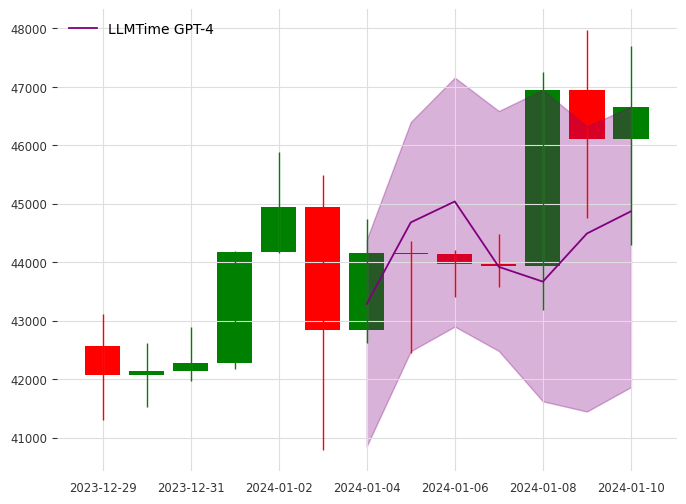

Data set : BTC_Daily_ohlc
from 2023-12-23 to 2023-01-01
training on 12 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]

targets [44153.09862627 44147.50536139 43969.91882947 43930.07673449
 46953.13121524 46110.76341917 46655.15188279]
median date
2024-01-04 09:00:00    43737.625221
2024-01-05 09:00:00    42993.426445
2024-01-06 09:00:00    43546.259821
2024-01-07 09:00:00    42738.272578
2024-01-08 09:00:00    43354.894422
2024-01-09 09:00:00    42802.061045
2024-01-10 09:00:00    43206.054666
dtype: float64
Raw list completion :
[['1022, 980, 1018, 961, 1015, 950, 982, 942, 986', '1025, 1008, 1022, 997, 1019, 998, 987, 988, ', '1039, 1044, 1010, 1004, 1019, 1042, 1027', '1051, 1014, 1046, 1016, 1006, 1003, 1008, ', '993, 1010, 1025, 1005, 990, 1008, 1023, 1003', '1051, 992, 1046, 983, 1041, 974, 1036, 965, ', '1050, 996, 1044, 1005, 1038, 1004, 1012, 103', '1018, 1036, 1014, 1022, 1020, 1013, 1019, ', '1021, 1011, 996, 990, 990, 1029, 1047, 998, ', '1031, 1044, 1057, 1008, 1021, 1034, 994, 100']]
Model :  LLMTime GPT-4
MAE :  1934.4359816045867
MAES :  5556498.776076908
dic_error_median :  {'input_len

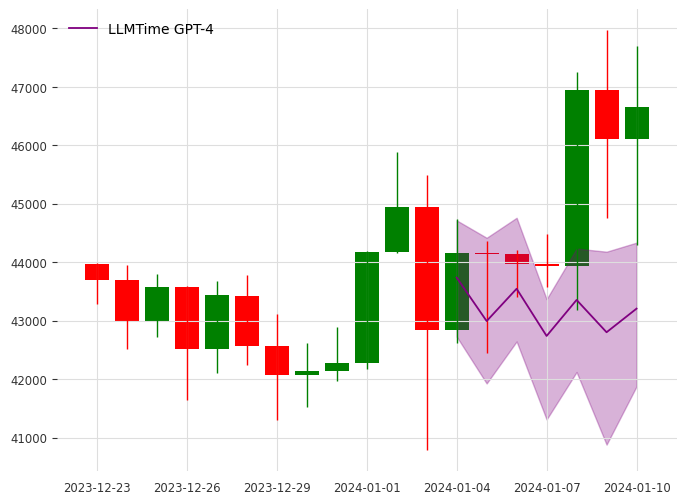

Data set : BTC_Daily_ohlc
from 2023-12-11 to 2023-01-01
training on 24 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.92s/it]

targets [44153.09862627 44147.50536139 43969.91882947 43930.07673449
 46953.13121524 46110.76341917 46655.15188279]
median date
2024-01-04 09:00:00    43376.115186
2024-01-05 09:00:00    43798.884340
2024-01-06 09:00:00    44369.622697
2024-01-07 09:00:00    44411.899613
2024-01-08 09:00:00    44348.484240
2024-01-09 09:00:00    43883.438171
2024-01-10 09:00:00    44094.822747
dtype: float64
Raw list completion :
[['1022, 1037, 1052, 1050, 1064, 1034, 1020, 104', '1053, 1030, 1062, 1055, 1081, 1085, 1082, 107', '1015, 1060, 1048, 1053, 1044, 1063, 1038, 105', '1014, 1023, 1060, 1067, 1055, 1047, 1050, 104', '1032, 1025, 1049, 1035, 1028, 1033, 1039, 104', '1047, 1046, 1045, 1042, 1023, 1005, 1046, 100', '1021, 1034, 1047, 1050, 1053, 1056, 1059, 106', '1029, 1053, 1064, 1025, 1036, 1007, 1018, 104', '1048, 1054, 1049, 1073, 1091, 1041, 1076, 108', '1004, 996, 1008, 1012, 1016, 1000, 998, 1003,']]
Model :  LLMTime GPT-4
MAE :  1342.776081104846
MAES :  2773943.6089212224
dic_error_media

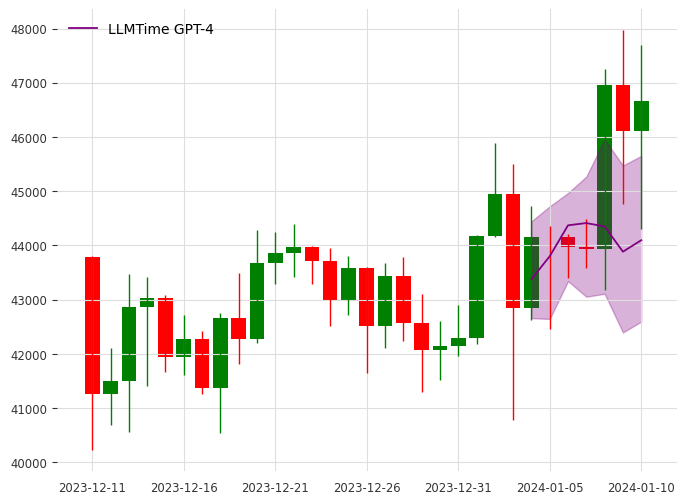

Data set : BTC_Daily_ohlc
from 2023-11-17 to 2023-01-01
training on 48 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]

targets [44153.09862627 44147.50536139 43969.91882947 43930.07673449
 46953.13121524 46110.76341917 46655.15188279]
median date
2024-01-04 09:00:00    43353.244602
2024-01-05 09:00:00    43702.086087
2024-01-06 09:00:00    43876.506830
2024-01-07 09:00:00    44574.189801
2024-01-08 09:00:00    44264.108480
2024-01-09 09:00:00    43973.407242
2024-01-10 09:00:00    44167.208068
dtype: float64
Raw list completion :
[['1108, 1115, 1124, 1156, 1163, 1117, 1124, 1131', '1151, 1115, 1154, 1156, 1108, 1151, 1153, 1105', '1128, 1134, 1120, 1108, 1123, 1131, 1119, 1130', '1124, 1140, 1128, 1166, 1154, 1147, 1158, 1148', '1101, 1110, 1131, 1127, 1161, 1137, 1154, 1164', '1096, 1105, 1145, 1161, 1112, 1109, 1136, 1157', '1108, 1150, 1145, 1138, 1165, 1174, 1142, 1152', '1135, 1146, 1132, 1162, 1161, 1128, 1112, 1143', '1112, 1120, 1137, 1143, 1129, 1111, 1136, 1148', '1133, 1137, 1084, 1100, 1107, 1148, 1153, 1101']]
Model :  LLMTime GPT-4
MAE :  1328.1601558982813
MAES :  2750110.193768342
dic_e

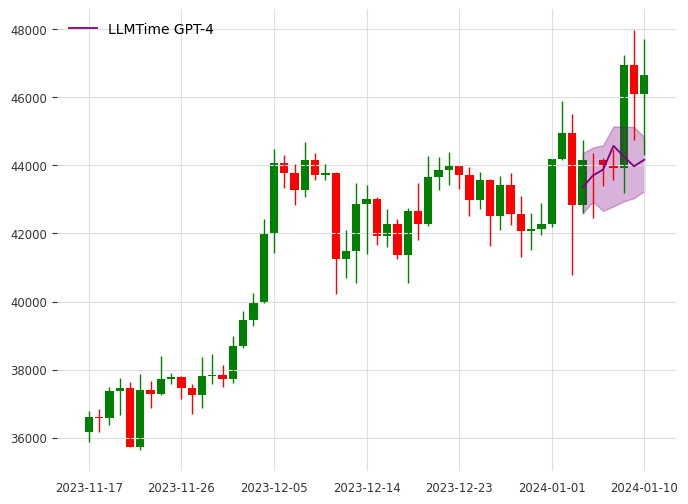

Data set : BTC_Daily_ohlc
from 2023-09-30 to 2023-01-01
training on 96 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


targets [44153.09862627 44147.50536139 43969.91882947 43930.07673449
 46953.13121524 46110.76341917 46655.15188279]
median date
2024-01-04 09:00:00    43366.093326
2024-01-05 09:00:00    43917.868669
2024-01-06 09:00:00    44297.214217
2024-01-07 09:00:00    44400.672093
2024-01-08 09:00:00    44693.802744
2024-01-09 09:00:00    44762.774662
2024-01-10 09:00:00    44469.644011
dtype: float64
Raw list completion :
[['1250, 1302, 1333, 1345, 1328, 1317, 1340, 1327', '1247, 1275, 1277, 1294, 1297, 1310, 1329, 1331', '1245, 1266, 1271, 1289, 1300, 1320, 1345, 1332', '1256, 1273, 1280, 1285, 1274, 1268, 1289, 1294', '1309, 1301, 1288, 1263, 1270, 1306, 1281, 1270', '1265, 1259, 1291, 1285, 1281, 1274, 1289, 1278', '1246, 1258, 1292, 1316, 1321, 1327, 1354, 1347', '1258, 1249, 1237, 1256, 1251, 1238, 1229, 1247', '1267, 1300, 1302, 1301, 1294, 1283, 1276, 1273', '1274, 1273, 1264, 1281, 1302, 1289, 1289, 1278']]
Model :  LLMTime GPT-4
MAE :  1086.7654055275696
MAES :  1814110.8716413619
dic_

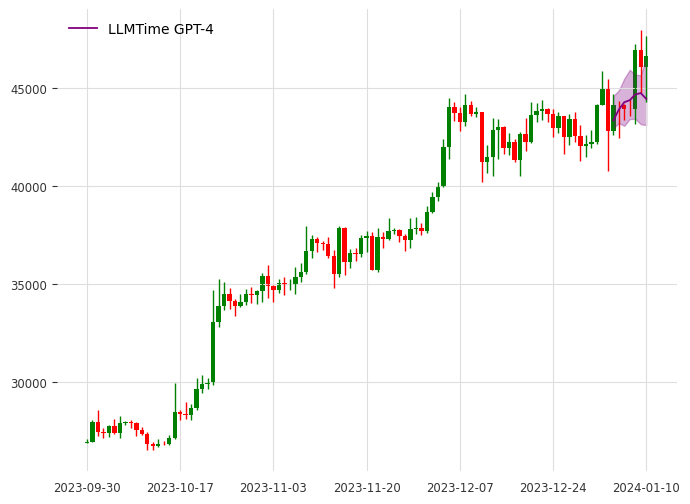

Data set : BTC_Daily_ohlc
from 2023-06-26 to 2023-01-01
training on 192 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:02<00:00,  2.57s/it]

targets [44153.09862627 44147.50536139 43969.91882947 43930.07673449
 46953.13121524 46110.76341917 46655.15188279]
median date
2024-01-04 09:00:00    42914.899671
2024-01-05 09:00:00    42998.717835
2024-01-06 09:00:00    43180.323855
2024-01-07 09:00:00    43278.111713
2024-01-08 09:00:00    43571.475285
2024-01-09 09:00:00    43767.050999
2024-01-10 09:00:00    43781.020693
dtype: float64
Raw list completion :
[['1533, 1557, 1541, 1538, 1576, 1601, 1566, 1527', '1536, 1539, 1552, 1555, 1556, 1567, 1571, 1572', '1535, 1521, 1527, 1529, 1532, 1535, 1541, 1543', '1589, 1580, 1586, 1574, 1543, 1554, 1542, 1536', '1538, 1538, 1541, 1545, 1555, 1564, 1567, 1570', '1530, 1549, 1552, 1592, 1575, 1568, 1590, 1598', '1529, 1528, 1532, 1541, 1563, 1565, 1556, 1558', '1536, 1560, 1559, 1552, 1562, 1567, 1572, 1580', '1539, 1532, 1506, 1502, 1534, 1536, 1517, 1520', '1531, 1530, 1549, 1555, 1562, 1583, 1598, 1591']]
Model :  LLMTime GPT-4
MAE :  1775.4351453899112
MAES :  4155797.554488141
dic_e

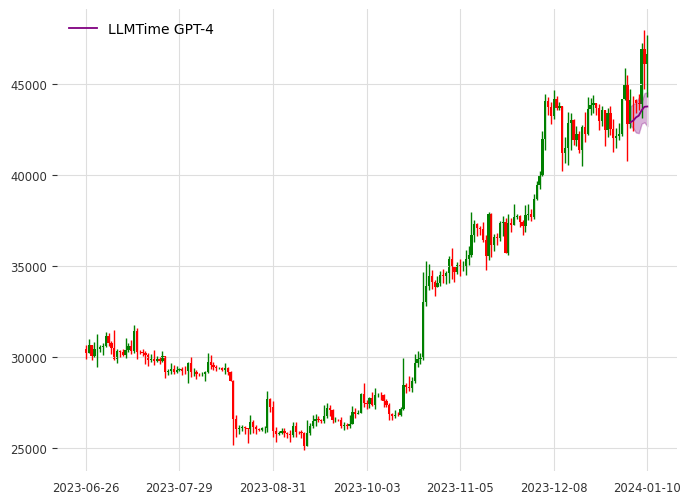

Two pickle files have been created one with MSE/MAE among all samples and the second with MSE/MAE among median only
The path for the pickle file are the following : 
pickle/dic_error_classic_2024-01-11_median.pkl
Data set : BTC_Daily_ohlc
from 2024-01-04 to 2023-01-01
training on 6 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.79s/it]

targets [46655.15188279 46340.17386131 42782.46093746 42847.84966598
 41731.61076632 42510.46841753 43137.60278385]
median date
2024-01-10 09:00:00    46525.999973
2024-01-11 09:00:00    46107.442208
2024-01-12 09:00:00    46107.442208
2024-01-13 09:00:00    46107.442208
2024-01-14 09:00:00    46107.442208
2024-01-15 09:00:00    46107.442208
2024-01-16 09:00:00    46107.442208
dtype: float64
Raw list completion :
[['1031, 1002, 1097, 1075', '1065, 1046', '1065, 1046', '1065, 1046, 988, 988', '1028, 1010', '1046, 1036, 1065, 1070, 1075, 1065, 1088', '1046, 1098, 1078', '1065, 1046', '1065, 1046', '1019, 1019, 1088, 1068']]
Model :  LLMTime GPT-4
MAE :  2555.5860045196814
MAES :  8951050.811936622
dic_error_median :  {'input_length': {6: {'Mae': 2555.5860045196814, 'Mse': 8951050.811936622}, 12: {'Mae': None, 'Mse': None}, 24: {'Mae': None, 'Mse': None}, 48: {'Mae': None, 'Mse': None}, 96: {'Mae': None, 'Mse': None}, 192: {'Mae': None, 'Mse': None}}}
Sequence lenght :  6
Raw scaled seque

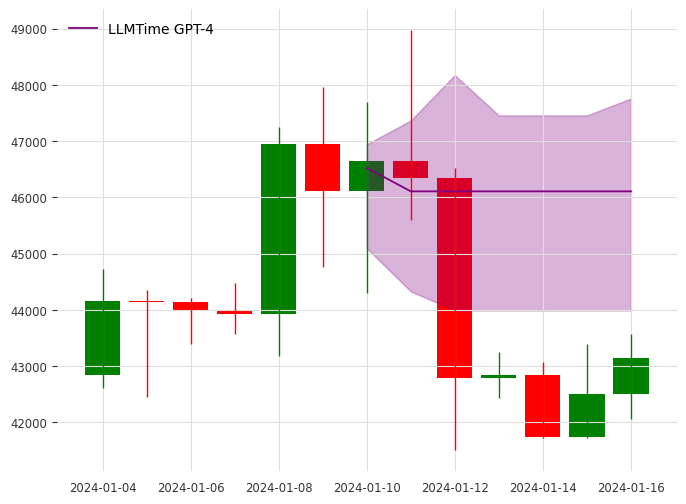

Data set : BTC_Daily_ohlc
from 2023-12-29 to 2023-01-01
training on 12 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.52s/it]

targets [46655.15188279 46340.17386131 42782.46093746 42847.84966598
 41731.61076632 42510.46841753 43137.60278385]
median date
2024-01-10 09:00:00    45696.853664
2024-01-11 09:00:00    46128.566972
2024-01-12 09:00:00    46236.495299
2024-01-13 09:00:00    46258.080964
2024-01-14 09:00:00    46646.622942
2024-01-15 09:00:00    46970.407923
2024-01-16 09:00:00    46905.650927
dtype: float64
Raw list completion :
[['1049, 1030, 1021, 1041, 1022, 1052, 1048, ', '1060, 1059, 1109, 1089, 1052, 1083, 1082, ', '1068, 1068, 1064, 1063, 1133, 1114, 1114, ', '1048, 1058, 1058, 1053, 1053, 1123, 1104', '1049, 1068, 1051, 1049, 1087, 1086, 1050, ', '1030, 1071, 1066, 1065, 1026, 1043, 1061, ', '1086, 1083, 1080, 1077, 1074, 1071, 1068, ', '1056, 1062, 1075, 1079, 1086, 1089, 1090', '1070, 1114, 1132, 1083, 1113, 1113, 1109, ', '1082, 1090, 1090, 1088, 1089, 1143, 1126']]
Model :  LLMTime GPT-4
MAE :  3025.310084551054
MAES :  11824247.959325762
dic_error_median :  {'input_length': {6: {'Mae': 25

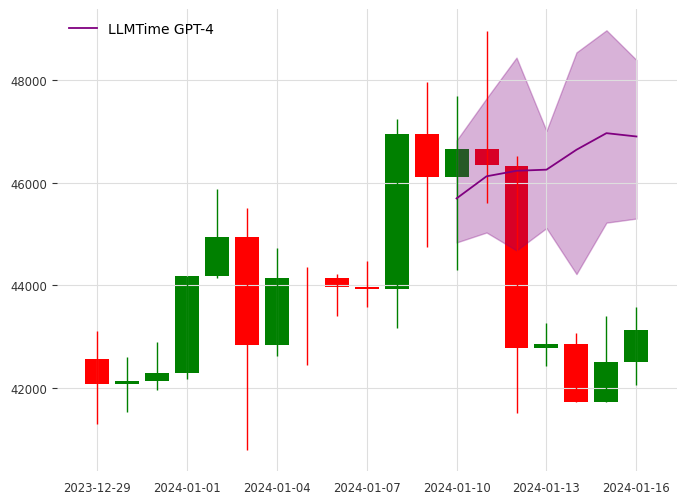

Data set : BTC_Daily_ohlc
from 2023-12-17 to 2023-01-01
training on 24 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.43s/it]

targets [46655.15188279 46340.17386131 42782.46093746 42847.84966598
 41731.61076632 42510.46841753 43137.60278385]
median date
2024-01-10 09:00:00    46187.932180
2024-01-11 09:00:00    46315.876590
2024-01-12 09:00:00    46337.200659
2024-01-13 09:00:00    46934.274574
2024-01-14 09:00:00    46934.274574
2024-01-15 09:00:00    46614.413548
2024-01-16 09:00:00    46635.737616
dtype: float64
Raw list completion :
[['1079, 1098, 1094, 1100, 1102, 1098, 1086, 109', '1099, 1100, 1110, 1115, 1100, 1090, 1100, 109', '1078, 1075, 1085, 1092, 1099, 1054, 1086, 106', '1086, 1094, 1100, 1108, 1117, 1121, 1128, 113', '1085, 1075, 1075, 1070, 1065, 1060, 1055, 105', '1072, 1091, 1086, 1100, 1100, 1095, 1125, 110', '1086, 1080, 1095, 1110, 1105, 1100, 1120, 111', '1079, 1076, 1082, 1107, 1112, 1106, 1105, 113', '1089, 1093, 1086, 1070, 1083, 1058, 1080, 106', '1080, 1075, 1069, 1066, 1064, 1062, 1058, 105']]
Model :  LLMTime GPT-4
MAE :  2991.0607677810744
MAES :  12242993.037657673
dic_error_medi

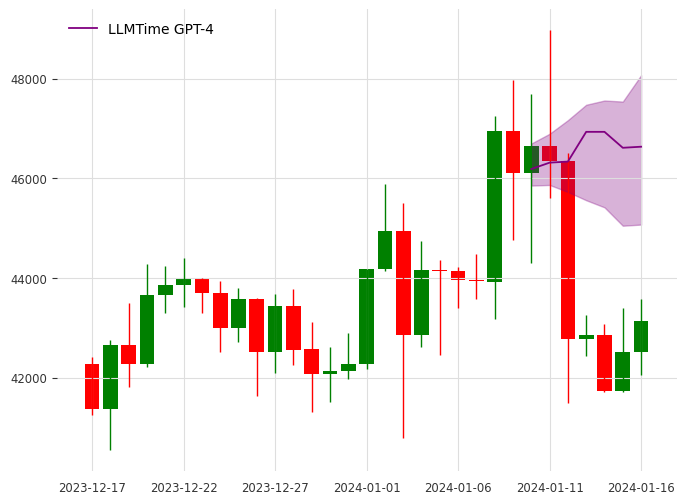

Data set : BTC_Daily_ohlc
from 2023-11-23 to 2023-01-01
training on 48 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:02<00:00,  2.09s/it]

targets [46655.15188279 46340.17386131 42782.46093746 42847.84966598
 41731.61076632 42510.46841753 43137.60278385]
median date
2024-01-10 09:00:00    45426.083096
2024-01-11 09:00:00    45761.640497
2024-01-12 09:00:00    45677.751147
2024-01-13 09:00:00    45887.474522
2024-01-14 09:00:00    46055.253222
2024-01-15 09:00:00    46369.838285
2024-01-16 09:00:00    46705.395686
dtype: float64
Raw list completion :
[['1082, 1087, 1086, 1091, 1096, 1122, 1117, 1124', '1082, 1112, 1088, 1124, 1107, 1079, 1108, 1119', '1106, 1111, 1090, 1120, 1130, 1136, 1125, 1118', '1081, 1080, 1095, 1103, 1099, 1107, 1112, 1116', '1101, 1069, 1079, 1072, 1062, 1068, 1089, 1088', '1083, 1085, 1079, 1068, 1092, 1111, 1114, 1103', '1077, 1105, 1083, 1096, 1109, 1130, 1118, 1120', '1100, 1105, 1102, 1082, 1067, 1069, 1073, 1074', '1094, 1094, 1089, 1104, 1114, 1102, 1100, 1132', '1073, 1072, 1100, 1083, 1084, 1103, 1129, 1123']]
Model :  LLMTime GPT-4
MAE :  2784.760348919272
MAES :  9397871.665240984
dic_er

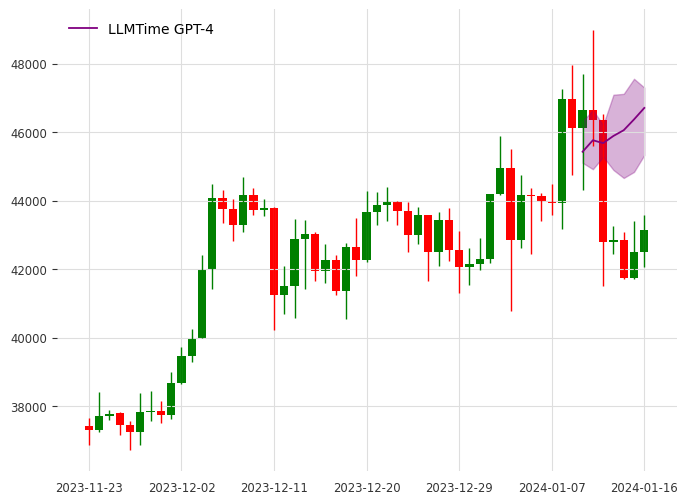

Data set : BTC_Daily_ohlc
from 2023-10-06 to 2023-01-01
training on 96 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.88s/it]

targets [46655.15188279 46340.17386131 42782.46093746 42847.84966598
 41731.61076632 42510.46841753 43137.60278385]
median date
2024-01-10 09:00:00    46011.149566
2024-01-11 09:00:00    46238.840827
2024-01-12 09:00:00    46431.502664
2024-01-13 09:00:00    46554.105651
2024-01-14 09:00:00    46413.987952
2024-01-15 09:00:00    46921.914612
2024-01-16 09:00:00    47149.605874
dtype: float64
Raw list completion :
[['1313, 1326, 1323, 1332, 1338, 1340, 1344, 1341', '1300, 1296, 1289, 1303, 1322, 1340, 1338, 1336', '1311, 1315, 1330, 1327, 1318, 1333, 1325, 1332', '1313, 1304, 1327, 1310, 1311, 1338, 1360, 1342', '1317, 1315, 1306, 1300, 1286, 1282, 1285, 1285', '1323, 1325, 1348, 1342, 1347, 1349, 1360, 1365', '1310, 1308, 1317, 1350, 1355, 1360, 1448, 1450', '1332, 1346, 1359, 1373, 1378, 1387, 1381, 1388', '1306, 1324, 1312, 1320, 1307, 1332, 1319, 1337', '1320, 1356, 1362, 1330, 1327, 1335, 1347, 1370']]
Model :  LLMTime GPT-4
MAE :  3029.494219022065
MAES :  12136932.678485218
dic_e

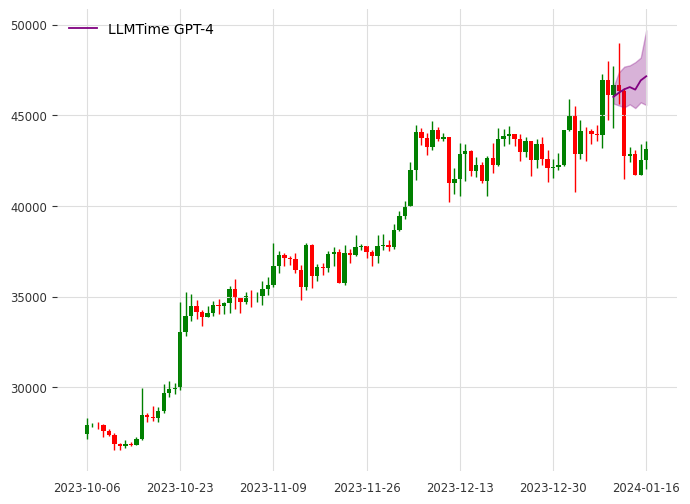

Data set : BTC_Daily_ohlc
from 2023-07-02 to 2023-01-01
training on 192 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:02<00:00,  2.43s/it]


targets [46655.15188279 46340.17386131 42782.46093746 42847.84966598
 41731.61076632 42510.46841753 43137.60278385]
median date
2024-01-10 09:00:00    45918.383860
2024-01-11 09:00:00    45946.323248
2024-01-12 09:00:00    45932.353554
2024-01-13 09:00:00    45820.596003
2024-01-14 09:00:00    45806.626309
2024-01-15 09:00:00    45834.565697
2024-01-16 09:00:00    45792.656615
dtype: float64
Raw list completion :
[['1640, 1628, 1615, 1607, 1612, 1629, 1621, 1658', '1642, 1640, 1654, 1655, 1660, 1648, 1639, 1640', '1644, 1645, 1662, 1639, 1627, 1623, 1628, 1633', '1642, 1648, 1645, 1649, 1688, 1713, 1686, 1663', '1647, 1643, 1645, 1642, 1646, 1652, 1649, 1650', '1642, 1637, 1622, 1640, 1638, 1633, 1628, 1632', '1647, 1653, 1656, 1619, 1615, 1651, 1690, 1683', '1648, 1646, 1642, 1634, 1630, 1626, 1622, 1618', '1640, 1635, 1638, 1640, 1640, 1635, 1645, 1638', '1653, 1646, 1640, 1638, 1650, 1645, 1638, 1632']]
Model :  LLMTime GPT-4
MAE :  2472.4891776062286
MAES :  7737382.136145468
dic_e

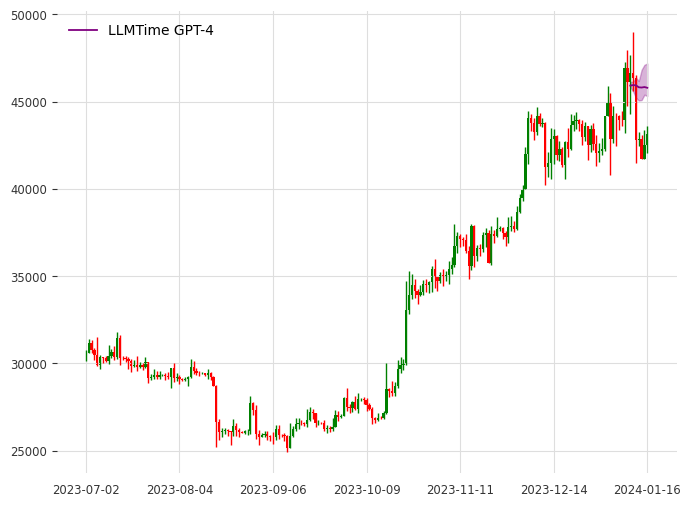

Two pickle files have been created one with MSE/MAE among all samples and the second with MSE/MAE among median only
The path for the pickle file are the following : 
pickle/dic_error_classic_2024-01-17_median.pkl
Data set : BTC_Daily_ohlc
from 2024-01-10 to 2023-01-01
training on 6 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.65s/it]

targets [43137.60278385 42774.27905937 41325.34582003 41657.42442203
 41695.00176365 41579.55169874 39565.94381016]
median date
2024-01-16 09:00:00    42049.414172
2024-01-17 09:00:00    42369.262657
2024-01-18 09:00:00    42049.414172
2024-01-19 09:00:00    42134.707101
2024-01-20 09:00:00    42134.707101
2024-01-21 09:00:00    42134.707101
2024-01-22 09:00:00    42134.707101
dtype: float64
Raw list completion :
[['981, 990, 977, 984', '992, 994, 980, 982, 965, 976', '985, 978, 963', '994, 992, 990', '986, 1000, 994, 998, 1002', '983, 987', '985, 997, 993, 998, 997, 999, 999, 1000, 100', '977, 998', '990, 983, 984, 958, 976, 970', '993, 994, 973, 988']]
Model :  LLMTime GPT-4
MAE :  894.0257252830894
MAES :  1314335.660959474
dic_error_median :  {'input_length': {6: {'Mae': 894.0257252830894, 'Mse': 1314335.660959474}, 12: {'Mae': None, 'Mse': None}, 24: {'Mae': None, 'Mse': None}, 48: {'Mae': None, 'Mse': None}, 96: {'Mae': None, 'Mse': None}, 192: {'Mae': None, 'Mse': None}}}
Sequen

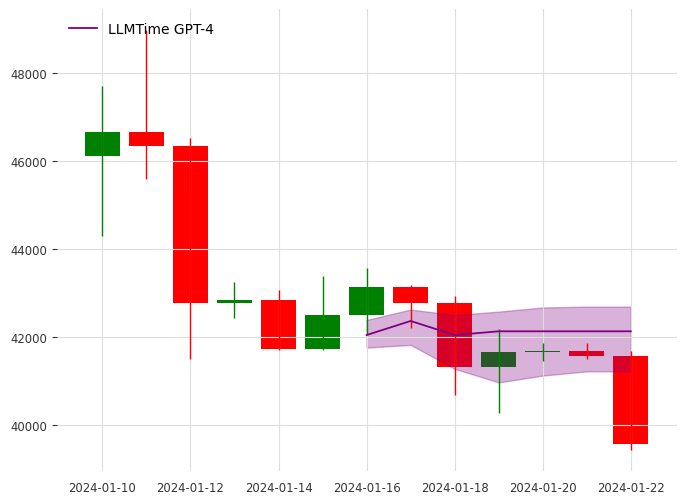

Data set : BTC_Daily_ohlc
from 2024-01-04 to 2023-01-01
training on 12 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:02<00:00,  2.38s/it]

targets [43137.60278385 42774.27905937 41325.34582003 41657.42442203
 41695.00176365 41579.55169874 39565.94381016]
median date
2024-01-16 09:00:00    42373.826207
2024-01-17 09:00:00    42438.584984
2024-01-18 09:00:00    41920.514771
2024-01-19 09:00:00    42352.239949
2024-01-20 09:00:00    42093.204842
2024-01-21 09:00:00    41877.342253
2024-01-22 09:00:00    41596.720887
dtype: float64
Raw list completion :
[['952, 974, 942, 966, 932, 958, 922, 950', '958, 972, 946, 964, 938, 956, 930', '951, 966, 943, 958, 936, 951, 928, 943', '1002, 1020, 1000, 1018, 998, 1016, 996, 1014', '955, 972, 942, 966, 935, 956, 926, 946, 918, 936', '974, 965, 953, 962, 956, 943, 941, 939, 932, 930', '988, 1002, 996, 1012, 1010, 1025, 1022', '991, 1007, 988, 1016, 1000, 1015, 994, 999', '995, 991, 989, 995, 993, 981, 985, 976, 979, 978', '1014, 1005, 1022, 1011, 1002, 998']]
Model :  LLMTime GPT-4
MAE :  730.8894054859868
MAES :  843477.1870509014
dic_error_median :  {'input_length': {6: {'Mae': 894.025

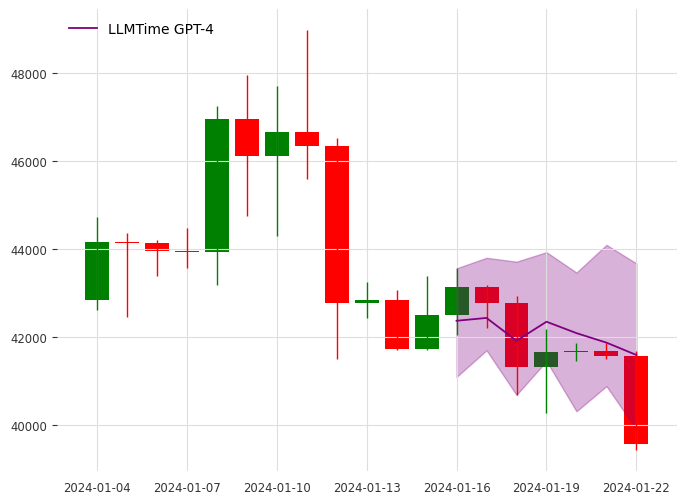

Data set : BTC_Daily_ohlc
from 2023-12-23 to 2023-01-01
training on 24 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:02<00:00,  2.06s/it]

targets [43137.60278385 42774.27905937 41325.34582003 41657.42442203
 41695.00176365 41579.55169874 39565.94381016]
median date
2024-01-16 09:00:00    42717.904410
2024-01-17 09:00:00    42995.848733
2024-01-18 09:00:00    43059.989731
2024-01-19 09:00:00    43038.609398
2024-01-20 09:00:00    43124.130729
2024-01-21 09:00:00    43615.878377
2024-01-22 09:00:00    44406.950681
dtype: float64
Raw list completion :
[['996, 1001, 1010, 1018, 1024, 1033, 1040, 1045', '1001, 1003, 980, 999, 1022, 1024, 1047, 1066,', '995, 1030, 1043, 1005, 1040, 1045, 1043, 1025', '988, 1022, 1005, 1019, 994, 1015', '1011, 977, 1008, 1008, 993, 1015, 1036, 1035,', '1000, 987, 1003, 982, 978, 1005, 1030, 1055, ', '1007, 978, 995, 989, 972, 972, 980, 1025, 1043,', '997, 1019, 1023, 1030, 1041, 1055, 1068, 1080', '992, 1007, 989, 982, 1001, 1013, 991, 1018, 102', '1000, 1023, 1017, 1007, 1015, 1040, 1043, 102']]
Model :  LLMTime GPT-4
MAE :  1723.3656355657138
MAES :  4966612.1063140035
dic_error_median :  {'i

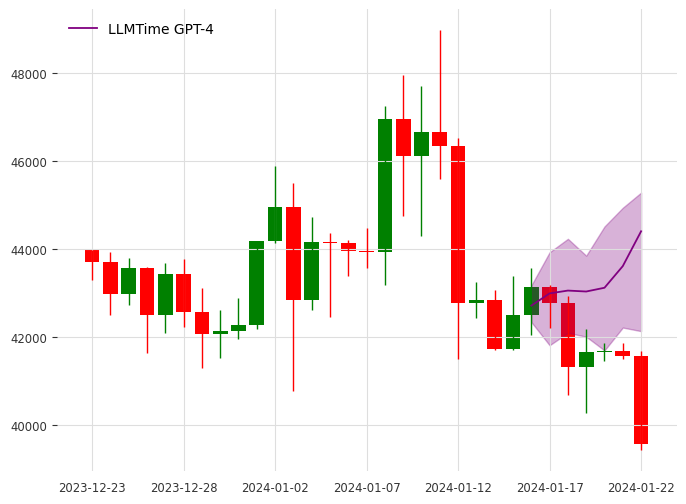

Data set : BTC_Daily_ohlc
from 2023-11-29 to 2023-01-01
training on 48 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:02<00:00,  2.09s/it]

targets [43137.60278385 42774.27905937 41325.34582003 41657.42442203
 41695.00176365 41579.55169874 39565.94381016]
median date
2024-01-16 09:00:00    42932.949540
2024-01-17 09:00:00    43017.504832
2024-01-18 09:00:00    43334.587178
2024-01-19 09:00:00    43799.641284
2024-01-20 09:00:00    44222.417744
2024-01-21 09:00:00    44159.001275
2024-01-22 09:00:00    44581.777735
dtype: float64
Raw list completion :
[['1022, 1015, 1008, 1035, 1042, 1039, 1055, 1056', '1002, 1027, 1024, 1015, 1029, 1006, 1037, 1061', '1004, 990, 1012, 1033, 1050, 1048, 1032, 1024,', '1002, 1019, 1025, 1041, 1093, 1088, 1090, 1056', '1020, 1008, 1015, 982, 992, 983, 1004, 1019, 102', '1023, 1060, 1053, 1066, 1049, 1098, 1057, 1048', '1024, 1028, 1040, 1036, 1042, 1036, 1053, 1047', '1010, 1007, 1029, 1048, 1060, 1108, 1157, 1150', '990, 986, 998, 1010, 1024, 1040, 1032, 1026, 101', '1025, 1056, 1043, 1068, 1072, 1080, 1101, 1098']]
Model :  LLMTime GPT-4
MAE :  2103.148102655621
MAES :  6703881.038137378
di

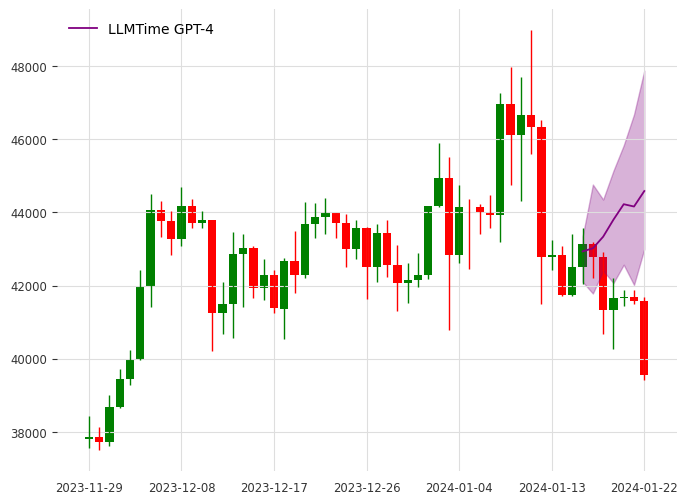

Data set : BTC_Daily_ohlc
from 2023-10-12 to 2023-01-01
training on 96 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:02<00:00,  2.45s/it]

targets [43137.60278385 42774.27905937 41325.34582003 41657.42442203
 41695.00176365 41579.55169874 39565.94381016]
median date
2024-01-16 09:00:00    42374.647031
2024-01-17 09:00:00    43070.483340
2024-01-18 09:00:00    43659.267910
2024-01-19 09:00:00    43944.739216
2024-01-20 09:00:00    43231.060950
2024-01-21 09:00:00    43802.003563
2024-01-22 09:00:00    43962.581173
dtype: float64
Raw list completion :
[['1181, 1146, 1149, 1185, 1201, 1216, 1248, 1253', '1210, 1218, 1227, 1235, 1243, 1251, 1260, 1268', '1172, 1204, 1220, 1191, 1177, 1193, 1198, 1212', '1184, 1186, 1239, 1261, 1201, 1240, 1240, 1235', '1201, 1209, 1233, 1232, 1241, 1204, 1213, 1221', '1181, 1233, 1190, 1246, 1204, 1250, 1240, 1240', '1190, 1225, 1226, 1219, 1230, 1236, 1228, 1235', '1208, 1217, 1236, 1230, 1218, 1241, 1225, 1218', '1178, 1180, 1188, 1237, 1244, 1193, 1235, 1230', '1196, 1183, 1208, 1206, 1198, 1218, 1212, 1227']]
Model :  LLMTime GPT-4
MAE :  1976.5064758208089
MAES :  5425432.8507972965
dic_

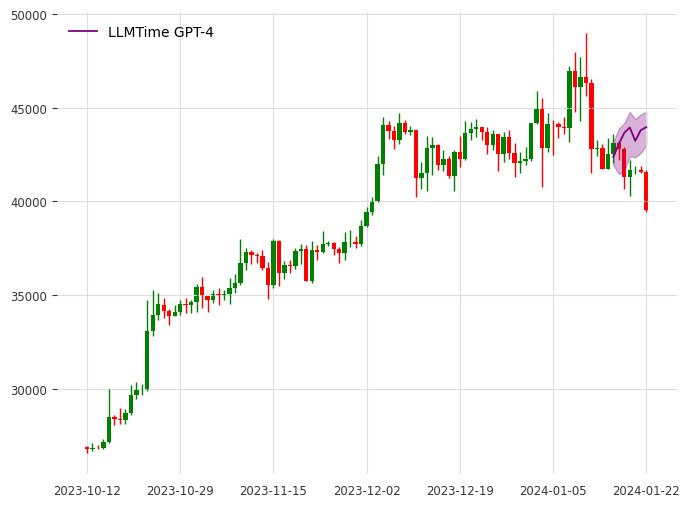

Data set : BTC_Daily_ohlc
from 2023-07-08 to 2023-01-01
training on 192 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]

targets [43137.60278385 42774.27905937 41325.34582003 41657.42442203
 41695.00176365 41579.55169874 39565.94381016]
median date
2024-01-16 09:00:00    42481.839160
2024-01-17 09:00:00    42775.202732
2024-01-18 09:00:00    42817.111814
2024-01-19 09:00:00    42663.445181
2024-01-20 09:00:00    42705.354263
2024-01-21 09:00:00    42775.202732
2024-01-22 09:00:00    43054.596610
dtype: float64
Raw list completion :
[['1528, 1543, 1532, 1528, 1524, 1530, 1559, 1562', '1496, 1561, 1556, 1575, 1574, 1571, 1654, 1655', '1522, 1548, 1556, 1571, 1583, 1595, 1607, 1621', '1520, 1538, 1554, 1536, 1529, 1539, 1546, 1583', '1522, 1524, 1523, 1523, 1520, 1521, 1526, 1530', '1515, 1516, 1532, 1525, 1530, 1518, 1515, 1520', '1520, 1535, 1512, 1520, 1527, 1531, 1542, 1526', '1511, 1513, 1538, 1476, 1485, 1534, 1539, 1501', '1524, 1526, 1531, 1533, 1529, 1527, 1526, 1528', '1517, 1481, 1482, 1509, 1500, 1512, 1517, 1523']]
Model :  LLMTime GPT-4
MAE :  1264.1614831039562
MAES :  2612651.750932299
dic_e

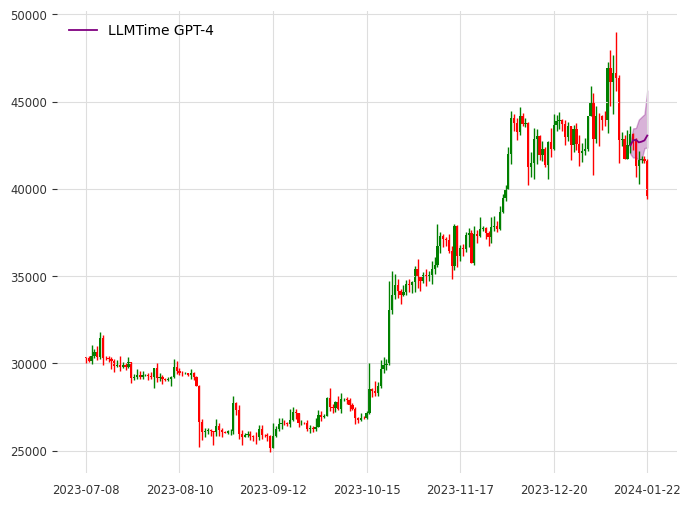

Two pickle files have been created one with MSE/MAE among all samples and the second with MSE/MAE among median only
The path for the pickle file are the following : 
pickle/dic_error_classic_2024-01-23_median.pkl


In [3]:
# datasets = get_bitcoin_datasets(predict_steps=30, start_date="2024-02-01")
# ds_name = 'BTC_BitHourly'
list_date = ["2023-11-30", "2023-12-06", "2023-12-12", "2023-12-18", "2023-12-24", "2023-12-30", "2024-01-05", "2024-01-11", "2024-01-17", "2024-01-23"]
for starting_date in list_date :
    index = 0

    dic_error_median = {"input_length" : {6: {"Mae": None, "Mse": None},
                                12: {"Mae": None, "Mse": None},
                                24: {"Mae": None, "Mse": None},
                                48: {"Mae": None, "Mse": None},
                                96: {"Mae": None, "Mse": None},
                                192: {"Mae": None, "Mse": None}}}

    predict_step = 7 
    for input_length in [6, 12, 24, 48, 96, 192] :

        train, test, df = get_bitcoin_datasets(input_length, predict_length = predict_step, end_date = starting_date)
        ds_name = 'BTC_Daily_ohlc'

        out = {}

        for i,model in enumerate(model_names): # GPT-4 takes a about a minute to run
            model_hypers[model].update({'dataset_name': ds_name}) # for promptcast
            hypers = list(grid_iter(model_hypers[model]))
            num_samples = 10
            pred_dict = get_autotuned_predictions_data(train, test, hypers, num_samples, model_predict_fns[model], verbose=False, parallel=False)

            targets = np.array(test)
            medians = pred_dict['median']
            print("targets", targets)
            print("median", medians)
            medians = medians.values

            mae = np.mean(np.abs(medians - test)) # (num_series)
            mse = np.mean(np.square(medians - test))
            pred_dict['maes'] = mse
            pred_dict['mae'] = mae

            out[model] = pred_dict

            print("Raw list completion :")
            print(pred_dict["completions_list"])

            print("Model : ", model)
            print("MAE : ", pred_dict['mae'])
            print("MAES : ", pred_dict['maes']) 

            dic_error_median["input_length"][input_length]["Mae"] = pred_dict['mae']
            dic_error_median["input_length"][input_length]["Mse"] = pred_dict['maes']
            print("dic_error_median : ",dic_error_median)


            string = out[model]['input_strs']
            string = str(string)
            number_comma = 0
            for elt in string :
                # print(elt)
                if elt == ',' :
                    number_comma += 1
            print("Sequence lenght : ", number_comma - 1)
            print("Raw scaled sequence")
            print(string)

            index_save = input_length
            current_folder =  starting_date + "_" + str(index_save)
            plot_preds_candles(df ,train, test, pred_dict, model, show_samples=False, save_index=current_folder)
        
        
    dic_name_median =  "pickle/dic_error_" + "classic" + "_" + starting_date + "_median" + ".pkl"

    with open(dic_name_median, 'wb') as fichier:
        pickle.dump(dic_error_median, fichier)

    print("Two pickle files have been created one with MSE/MAE among all samples and the second with MSE/MAE among median only")
    print(f"The path for the pickle file are the following : ")
    print(dic_name_median)


        


In [4]:
list_date = ["2023-11-30", "2023-12-06", "2023-12-12", "2023-12-18", "2023-12-24", "2023-12-30", "2024-01-05", "2024-01-11", "2024-01-17", "2024-01-23"]
dic_error_7_median =      {"input_length" : {6: {"Mae": [], "Mse": []},
                                12: {"Mae": [], "Mse": []},
                                24: {"Mae": [], "Mse": []},
                                48: {"Mae": [], "Mse": []},
                                96: {"Mae": [], "Mse": []},
                                192: {"Mae": [], "Mse": []}}}
for elt_date in list_date :
    path = "pickle/dic_error_classic_" + elt_date + "_median.pkl"
    with open(path, 'rb') as fichier:
        dic_error = pickle.load(fichier)

    for elt in dic_error_7_median["input_length"].items() :
        list = dic_error["input_length"][elt[0]]["Mae"]
        dic_error_7_median["input_length"][elt[0]]["Mae"].append(np.mean(list))
    
for elt in dic_error_7_median["input_length"].items() :
    inter = dic_error_7_median["input_length"][elt[0]]["Mae"] 
    inter = np.mean(inter)
    dic_error_7_median["input_length"][elt[0]]["Mae"] = inter

In [5]:
def table_display (dic_error_number) :
    table = []
    for key, value in dic_error_number['input_length'].items():
        row = [key, value['Mae'], value['Mse']]
        table.append(row)

    # En-tête du tableau
    headers = ['input_length', 'Mae', 'Mse']

    # Affichage du tableau
    print(tabulate(table, headers=headers))

print(dic_error_7_median)
table_display(dic_error_7_median)

{'input_length': {6: {'Mae': 1815.624991274263, 'Mse': []}, 12: {'Mae': 1848.960162027241, 'Mse': []}, 24: {'Mae': 1895.3413277136665, 'Mse': []}, 48: {'Mae': 1589.1111483578404, 'Mse': []}, 96: {'Mae': 1556.5938587056062, 'Mse': []}, 192: {'Mae': 1442.823415242441, 'Mse': []}}}
  input_length      Mae  Mse
--------------  -------  -----
             6  1815.62  []
            12  1848.96  []
            24  1895.34  []
            48  1589.11  []
            96  1556.59  []
           192  1442.82  []


In [20]:
with open("pickle/dic_error_classic_median.pkl", 'rb') as fichier:
        dict_error_median = pickle.load(fichier)


print(dic_error_median)

def display_tab (dic_error_number) :
    table = []
    for key, value in dic_error_number['input_length'].items():
        row = [key, value['Mae'], value['Mse']]
        table.append(row)

    # En-tête du tableau
    headers = ['input_length', 'Mae', 'Mse']

    # Affichage du tableau
    print(tabulate(table, headers=headers))

display_tab(dic_error_median)

{'input_length': {6: {'Mae': 3184.2164379947885, 'Mse': 13087684.392711189}, 12: {'Mae': 2373.3541898942835, 'Mse': 7999141.078329499}, 24: {'Mae': 2456.0923911928185, 'Mse': 8344978.4205345}, 48: {'Mae': 973.7839969497093, 'Mse': 1144665.4129625}, 96: {'Mae': 325.80371064508137, 'Mse': 129955.77830199001}, 192: {'Mae': 813.1084146194532, 'Mse': 764574.6859048309}}}
  input_length       Mae               Mse
--------------  --------  ----------------
             6  3184.22        1.30877e+07
            12  2373.35        7.99914e+06
            24  2456.09        8.34498e+06
            48   973.784       1.14467e+06
            96   325.804  129956
           192   813.108  764575


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:04<00:00,  4.22s/it]


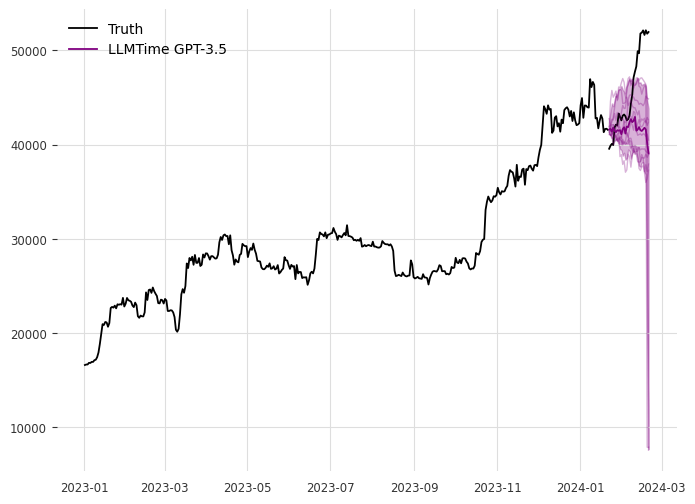

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:05<00:00,  5.18s/it]

<Figure size 640x480 with 0 Axes>

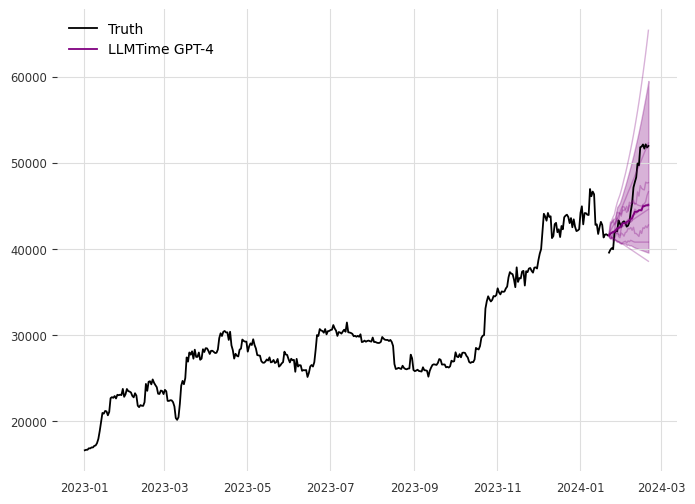

Model :  LLMTime GPT-3.5
Sequence lenght :  386
(' 2 5 2 , 2 5 4 , 2 5 4 , 2 5 9 , 2 5 8 , 2 6 1 , 2 6 1 , 2 6 6 , 2 6 8 , 2 7 5 , 2 8 9 , 3 1 4 , 3 4 4 , 3 7 3 , 3 7 0 , 3 7 9 , 3 7 8 , 3 6 5 , 3 7 6 , 4 2 0 , 4 2 3 , 4 2 1 , 4 2 7 , 4 1 9 , 4 3 1 , 4 3 0 , 4 3 1 , 4 3 0 , 4 5 0 , 4 2 4 , 4 3 3 , 4 5 0 , 4 4 3 , 4 4 1 , 4 3 8 , 4 2 7 , 4 2 3 , 4 3 6 , 4 2 8 , 3 9 6 , 3 9 1 , 3 9 8 , 3 9 6 , 3 9 5 , 4 0 7 , 4 6 6 , 4 4 4 , 4 7 3 , 4 7 5 , 4 6 5 , 4 8 0 , 4 7 0 , 4 6 2 , 4 5 5 , 4 3 4 , 4 3 4 , 4 4 5 , 4 4 3 , 4 3 3 , 4 4 7 , 4 4 2 , 4 1 1 , 4 1 1 , 4 1 4 , 4 1 3 , 4 0 7 , 3 9 3 , 3 5 6 , 3 5 0 , 3 5 9 , 4 0 2 , 4 6 0 , 4 7 6 , 4 6 5 , 4 8 5 , 5 5 1 , 5 3 8 , 5 6 7 , 5 6 0 , 5 7 1 , 5 4 7 , 5 7 6 , 5 5 3 , 5 5 3 , 5 6 7 , 5 4 4 , 5 4 8 , 5 7 8 , 5 6 9 , 5 8 1 , 5 8 1 , 5 7 3 , 5 6 3 , 5 7 3 , 5 7 3 , 5 6 9 , 5 6 6 , 5 6 6 , 5 7 7 , 6 1 4 , 6 2 9 , 6 2 1 , 6 3 4 , 6 3 7 , 6 3 2 , 6 3 2 , 6 0 8 , 6 3 4 , 5 9 0 , 5 7 5 , 5 4 8 , 5 6 3 , 5 5 7 , 5 5 5 , 5 7 6 , 5 8 0 , 6 0 9 , 6 0 5 , 6 0 2

100%|██████████| 1/1 [00:14<00:00, 14.16s/it]

<Figure size 640x480 with 0 Axes>

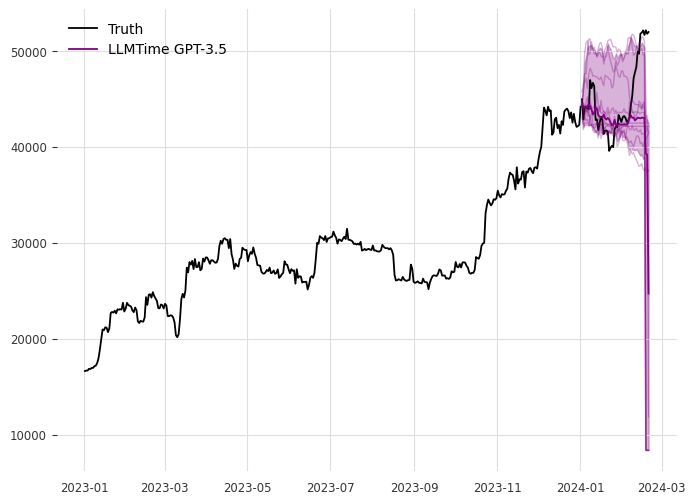

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:09<00:00,  9.30s/it]

<Figure size 640x480 with 0 Axes>

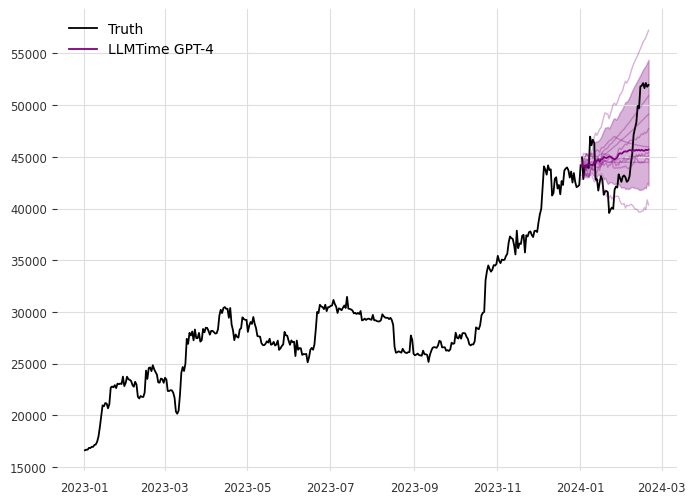

Model :  LLMTime GPT-3.5
Sequence lenght :  366
(' 2 4 2 , 2 4 4 , 2 4 4 , 2 4 9 , 2 4 8 , 2 5 2 , 2 5 2 , 2 5 7 , 2 5 8 , 2 6 6 , 2 8 1 , 3 0 7 , 3 3 9 , 3 6 9 , 3 6 7 , 3 7 6 , 3 7 4 , 3 6 1 , 3 7 3 , 4 1 9 , 4 2 3 , 4 2 1 , 4 2 7 , 4 1 8 , 4 3 1 , 4 2 9 , 4 3 1 , 4 3 0 , 4 5 1 , 4 2 4 , 4 3 3 , 4 5 1 , 4 4 3 , 4 4 2 , 4 3 9 , 4 2 7 , 4 2 2 , 4 3 6 , 4 2 8 , 3 9 4 , 3 8 9 , 3 9 6 , 3 9 3 , 3 9 3 , 4 0 6 , 4 6 8 , 4 4 4 , 4 7 5 , 4 7 7 , 4 6 6 , 4 8 3 , 4 7 2 , 4 6 4 , 4 5 7 , 4 3 5 , 4 3 4 , 4 4 5 , 4 4 4 , 4 3 3 , 4 4 8 , 4 4 3 , 4 1 0 , 4 1 0 , 4 1 2 , 4 1 2 , 4 0 6 , 3 9 1 , 3 5 2 , 3 4 6 , 3 5 5 , 4 0 0 , 4 6 2 , 4 7 8 , 4 6 7 , 4 8 8 , 5 5 8 , 5 4 4 , 5 7 5 , 5 6 7 , 5 7 9 , 5 5 4 , 5 8 4 , 5 6 0 , 5 6 0 , 5 7 5 , 5 5 0 , 5 5 4 , 5 8 6 , 5 7 7 , 5 8 9 , 5 8 9 , 5 8 1 , 5 7 0 , 5 8 1 , 5 8 1 , 5 7 7 , 5 7 3 , 5 7 4 , 5 8 5 , 6 2 4 , 6 4 0 , 6 3 1 , 6 4 5 , 6 4 8 , 6 4 3 , 6 4 3 , 6 1 8 , 6 4 6 , 5 9 9 , 5 8 3 , 5 5 4 , 5 7 0 , 5 6 4 , 5 6 1 , 5 8 5 , 5 8 8 , 6 1 9 , 6 1 4 , 6 1 2

100%|██████████| 1/1 [00:14<00:00, 14.53s/it]

<Figure size 640x480 with 0 Axes>

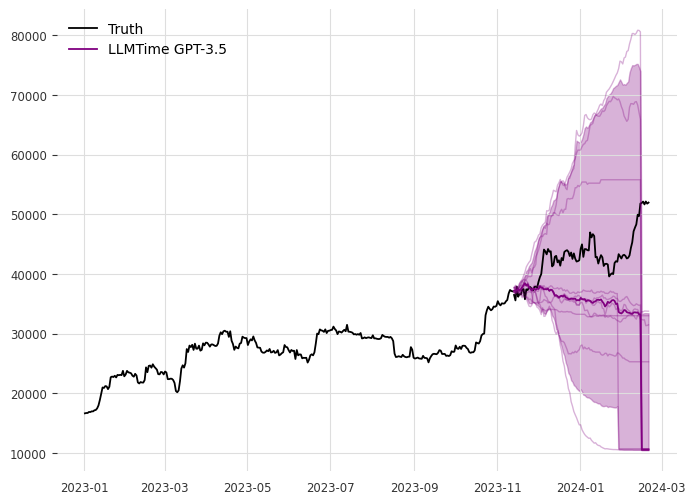

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:22<00:00, 22.34s/it]

<Figure size 640x480 with 0 Axes>

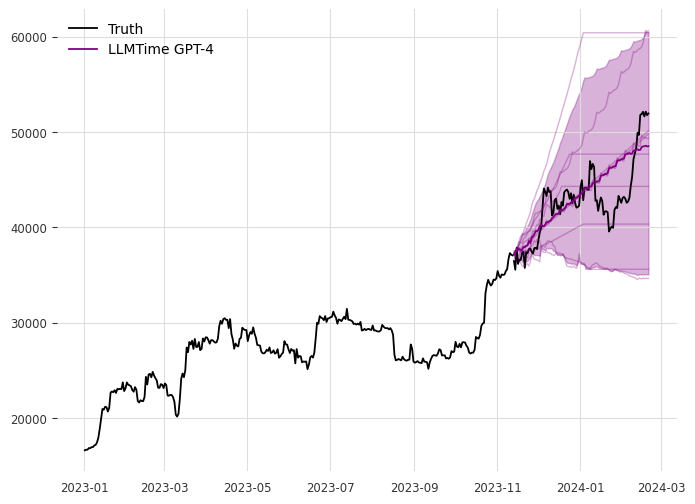

Model :  LLMTime GPT-3.5
Sequence lenght :  316
(' 2 6 0 , 2 6 2 , 2 6 2 , 2 7 0 , 2 6 9 , 2 7 4 , 2 7 4 , 2 8 1 , 2 8 4 , 2 9 5 , 3 1 6 , 3 5 4 , 3 9 9 , 4 4 2 , 4 3 9 , 4 5 2 , 4 5 0 , 4 3 0 , 4 4 7 , 5 1 4 , 5 1 9 , 5 1 6 , 5 2 4 , 5 1 3 , 5 3 1 , 5 2 8 , 5 3 1 , 5 2 9 , 5 5 9 , 5 2 1 , 5 3 3 , 5 5 9 , 5 4 8 , 5 4 6 , 5 4 2 , 5 2 5 , 5 1 8 , 5 3 8 , 5 2 6 , 4 7 7 , 4 7 0 , 4 8 0 , 4 7 7 , 4 7 6 , 4 9 4 , 5 8 4 , 5 5 0 , 5 9 4 , 5 9 6 , 5 8 1 , 6 0 5 , 5 8 9 , 5 7 8 , 5 6 7 , 5 3 6 , 5 3 5 , 5 5 1 , 5 4 9 , 5 3 4 , 5 5 4 , 5 4 7 , 5 0 1 , 5 0 1 , 5 0 4 , 5 0 3 , 4 9 4 , 4 7 4 , 4 1 7 , 4 0 8 , 4 2 1 , 4 8 6 , 5 7 5 , 5 9 8 , 5 8 2 , 6 1 2 , 7 1 2 , 6 9 2 , 7 3 7 , 7 2 6 , 7 4 2 , 7 0 6 , 7 5 0 , 7 1 5 , 7 1 5 , 7 3 7 , 7 0 1 , 7 0 7 , 7 5 2 , 7 3 9 , 7 5 7 , 7 5 7 , 7 4 5 , 7 2 9 , 7 4 5 , 7 4 5 , 7 3 9 , 7 3 4 , 7 3 5 , 7 5 1 , 8 0 7 , 8 3 0 , 8 1 7 , 8 3 8 , 8 4 1 , 8 3 4 , 8 3 5 , 7 9 8 , 8 3 8 , 7 7 1 , 7 4 8 , 7 0 7 , 7 3 0 , 7 2 1 , 7 1 7 , 7 5 0 , 7 5 5 , 8 0 0 , 7 9 3 , 7 9 0

<Figure size 640x480 with 0 Axes>

In [32]:
index = 0
for predict_step in [30,50,100] :
    starting_date = "2023-01-01"
    datasets = get_bitcoin_datasets(predict_steps=predict_step, start_date=starting_date)
    ds_name = 'BTC_Daily_ohlc'

    data = datasets[ds_name]
    train, test = data # or change to your own data
    out = {}
    for model in model_names: # GPT-4 takes a about a minute to run
        model_hypers[model].update({'dataset_name': ds_name}) # for promptcast
        hypers = list(grid_iter(model_hypers[model]))
        num_samples = 10
        pred_dict = get_autotuned_predictions_data(train, test, hypers, num_samples, model_predict_fns[model], verbose=False, parallel=False)
        out[model] = pred_dict
        index += 1
        plot_preds(train, test, pred_dict, model, show_samples=True, save_index=index)


    for model in model_names[:-1]: # GPT-4 takes a about a minute to run
        print("Model : ", model)
        string = out[model]['input_strs']
        string = str(string)
        number_comma = 0
        for elt in string :
            # print(elt)
            if elt == ',' :
                number_comma += 1
        print("Sequence lenght : ", number_comma - 1)
        print(string)


    with open(f"datasets/bitcoin/BTC_Daily_ohlc.csv") as f:
        df = pd.read_csv(f, usecols=[0, 4], parse_dates=[0])
        mask = (df["date"] > starting_date) 
        df = df.loc[mask]

        start_date = df["date"].iloc[0]
        end_date = df["date"].iloc[-1]

        print("Data set : BTC_Daily_ohlc")
        print(f"from {start_date} to {end_date}")
        print(f"{df.shape[0]} data points, training on {df.shape[0]- predict_step} and forecasting on {predict_step} points")
        print("Imput is scaled closing price")

        # df['close'] = df['close'].astype(float)
        # series = pd.Series(df['close'].values, index=df['date'])


## Running LLMTime and Visualizing Results ##

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AirPassengersDataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.60s/it]


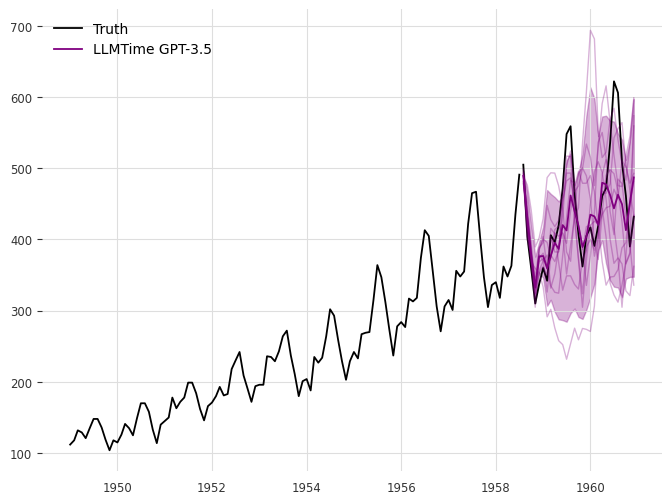

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AirPassengersDataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:05<00:00,  5.39s/it]


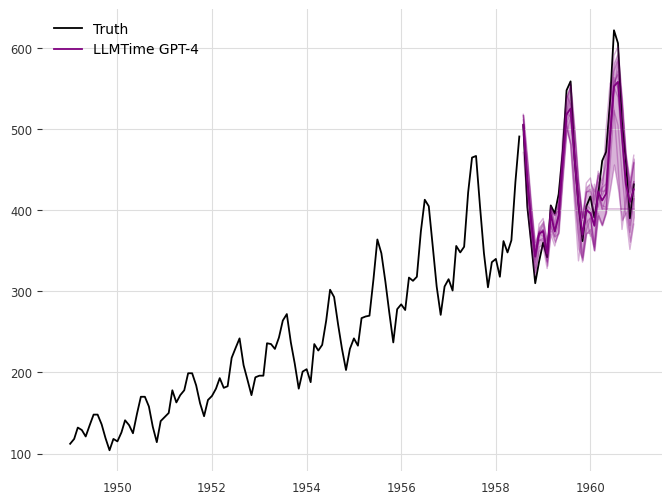

Train length: 86, Val length: 29


Hyperparameter search:   0%|          | 0/4 [00:00<?, ?it/s]/home/william/anaconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/william/anaconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/william/anaconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/william/anaconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization

Sampling with best hyper... defaultdict(<class 'dict'>, {'p': 12, 'd': 2, 'q': 0, 'dataset_name': 'AirPassengersDataset'}) 
 with NLL 3.747898


/home/william/anaconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/william/anaconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/william/anaconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


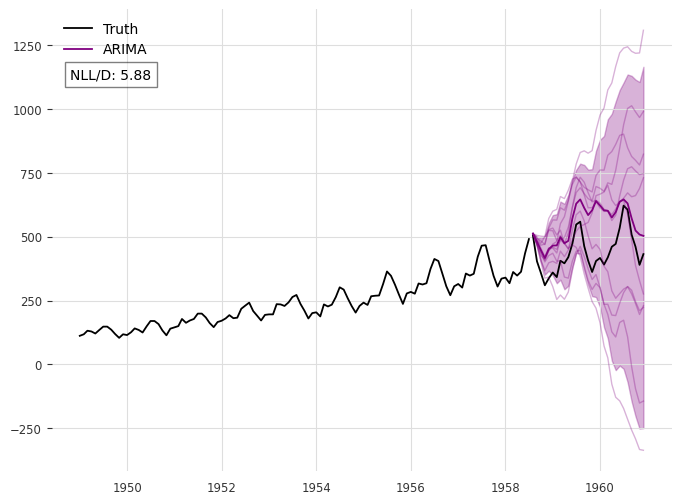

In [16]:
datasets = get_datasets()
ds_name = 'AirPassengersDataset'

data = datasets[ds_name]
train, test = data # or change to your own data
out = {}
for model in model_names: # GPT-4 takes a about a minute to run
    model_hypers[model].update({'dataset_name': ds_name}) # for promptcast
    hypers = list(grid_iter(model_hypers[model]))
    num_samples = 10
    pred_dict = get_autotuned_predictions_data(train, test, hypers, num_samples, model_predict_fns[model], verbose=False, parallel=False)
    out[model] = pred_dict
    plot_preds(train, test, pred_dict, model, show_samples=True)